In [1]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno
import random
import re
from scipy.stats import kstest
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score,roc_curve
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from scipy.stats import chi2_contingency
from scipy.stats import kstest
from scipy.stats import chisquare
# from mixed_naive_bayes import MixedNB


# 데이터 설명

Data Description
In this competition, you will predict the probability that an auto insurance policy holder files a claim.

In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder.

본 데이터는 Porto Seguro라는 보험사에서 약 5년 전에 kaggle이라는 데이터분석 플랫폼에 공개한 데이터이다. 각 변수들이 정확히 무엇을 뜻하는지는 공개되어 있지 않고, 그저 데이터 유형을 파악할 수 있는 정도의 최소 정보만이 공개되어 있다. '\~bin'으로 끝나는 변수는 binary 변수, '\~cat'으로 끝난다면 nominal categorical 변수, 그 외는 continuous 또는 ordinal categorical 변수이다. -1는 결측치라는 정보가 제공되어 있다. Y변수는 binary 변수이다. 

test.csv 파일은 kaggle submission 제출용이라 라벨링된 Y변수가 없는 것으로 나와 train.csv만 사용하였다.  

먼저 분석결과의 consistency를 위해 seed를 1111로 고정해놓겠다. 

In [42]:
random.seed(1111)

먼저 binary변수로 주어진 Y변수의 비율을 확인해보고, 단순한 binary classification 또는 Anomaly Detection 중 어떠한 문제로 접근하는게 좋을지 결정해야 한다. 

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
del train['id']
del test['id']

train_y = train['target']
# del train['target']

21694
573518


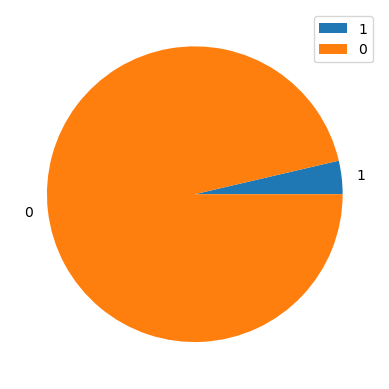

0.036447517859182946 0.963552482140817


In [44]:
print(sum(train_y==1))
print(sum(train_y==0))

ratio = np.array([sum(train_y==1), sum(train_y==0)])
labels = ["1", "0"]

plt.pie(ratio, labels = labels)
plt.legend()
plt.show()

print(21694/(21694 + 573518), 573518/(21694 + 573518))

binary변수인 Y변수에서 약 96대4의 비율로 각 클래스가 할당되어 있는 것을 확인하였고, class imbalance가 매우 심한 것을 확인하였다. 이 경우 모델 성능 평가를 단순 accuracy로 할 경우, True Positive와 True Negative에만 의존하는 수식구조상, 단순히 0으로만 예측하여도 매우 높은 성능이 나오기 때문에 좋은 모델이 나오기 기대하기 어렵다. 이러한 이유로 class imbalance인 모델의 성능평가로 적합한 F1-score 또는 Normalized Gini Index를 사용하는 것이 좋을 것이라 생각된다. 본 분석에서는 이상치라 하여도 소수 클래스인 1이 21694행이나 있다는 것을 고려하여 속도 Normalized Gini Index에 비해 속도적으로 우월한 F1-score를 사용하기로 하였다. 

# Preprocessing

In [52]:
col_names = list(train.columns)
col_names = col_names[1:]

In [45]:
for i in range(len(col_names)):
    for j in range(595212):
        if train[col_names[i]][j] == -1:
            train[col_names[i]][j] = np.nan
        else:
            pass

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


/opt/conda/lib/python3.7/site-packages/missingno/missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  "Plotting a sparkline on an existing axis is not currently supported. "


<AxesSubplot:>

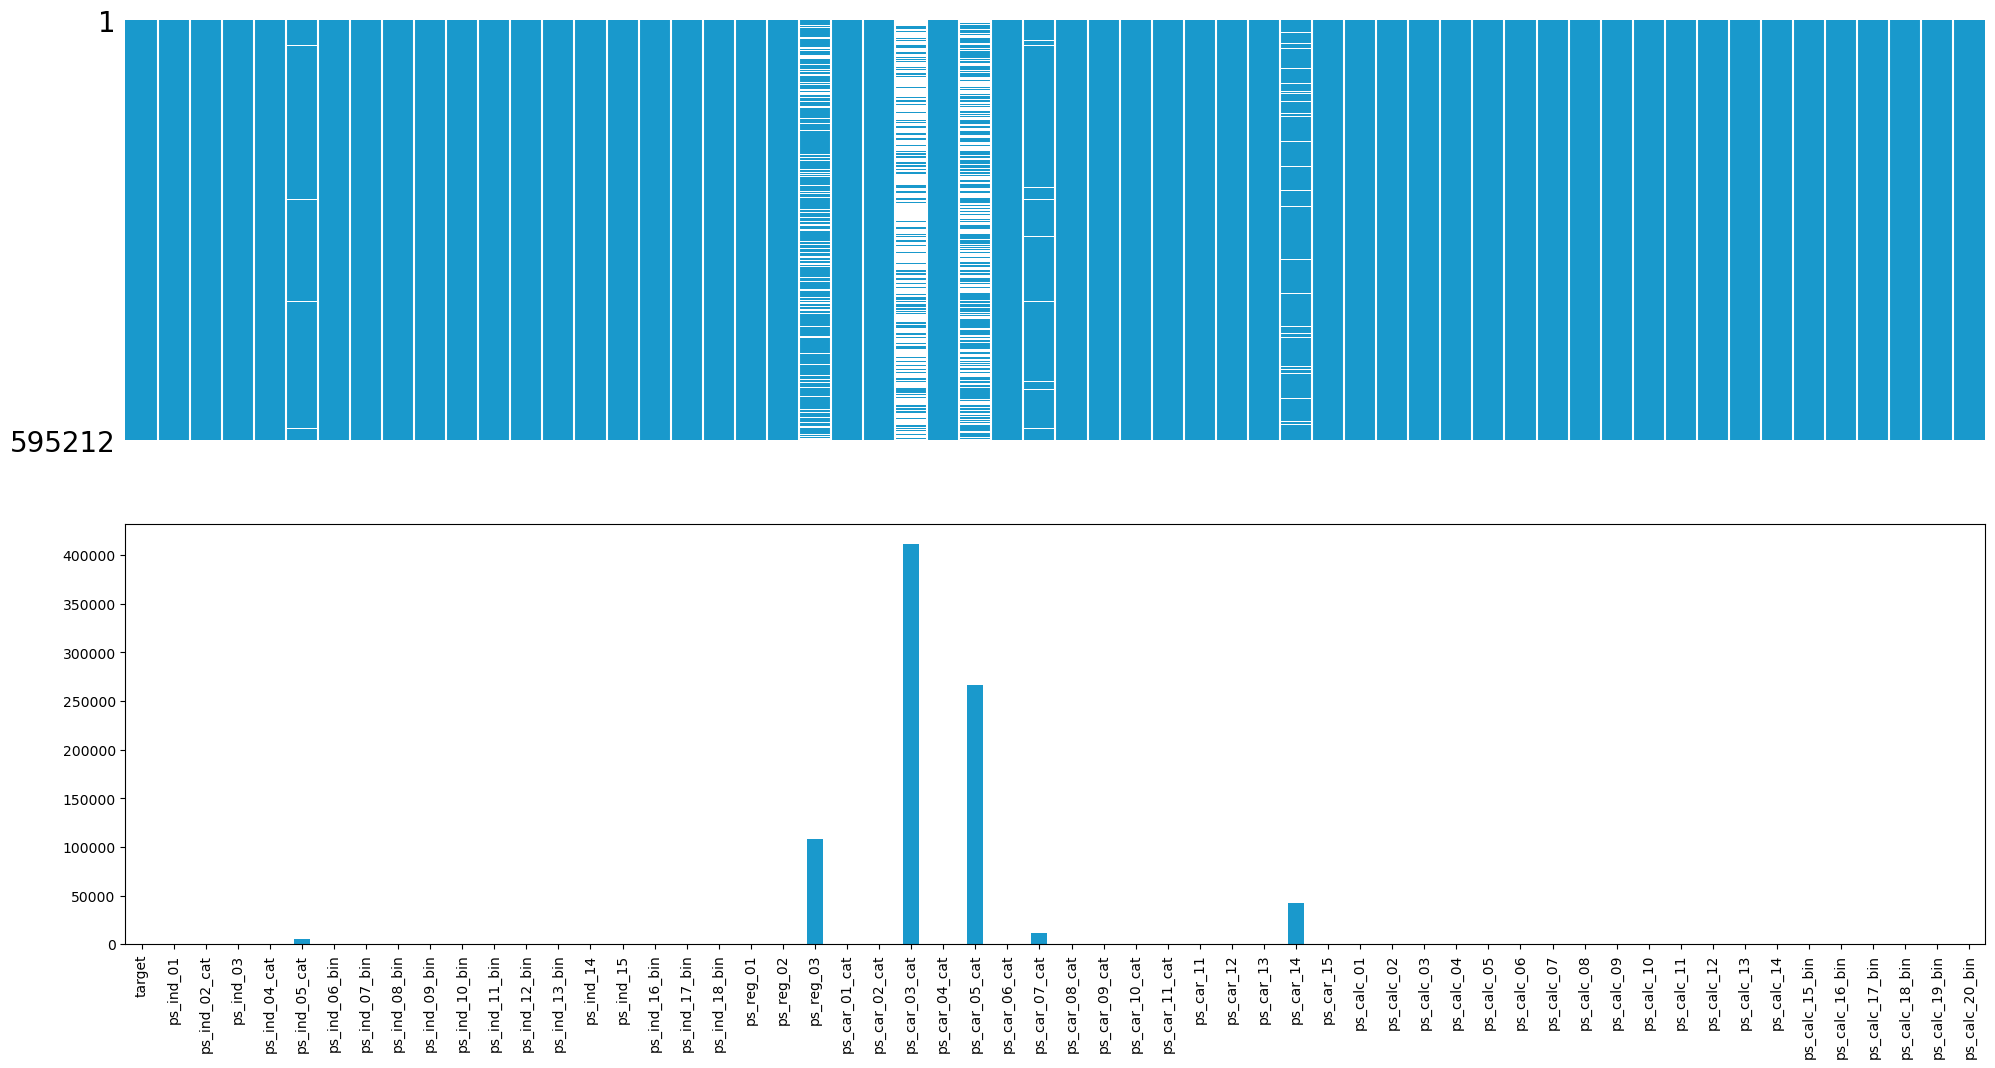

In [46]:
figure, axs = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(24,12)

msno.matrix(df=train.iloc[:, :], color=(0.1, 0.6, 0.8),ax=axs[0])
train.isna().sum().plot.bar(figsize = (24,12),color=(0.1, 0.6, 0.8))

주어진 데이터에 결측치 보간을 진행해주기 위해 msno 라이브러리를 사용하여 결측치 시각화를 진행하였다. 결측치는 -1로 표기되었다는 데이터 설명을 참고하여, -1을 모두 nan으로 변환해주었고, 시각화를 확인해본 결과, ps_car_03_cat변수와 ps_car_05_cat변수는 결측치 비율이 40%를 상회하여 결측치 보간이 의미가 없을 것이라 생각하여 폐기하기로 결정하였다. 

In [48]:
del train['ps_car_03_cat']
del train['ps_car_05_cat']

Porto Seguro 측에서 시계열 데이터라는 언급이 없었기에 cross-sectional data라고 간주하겠다. 또한, 위 msno를 이용한 시각화를 통해 결측 index자체에는 패턴이 없는 것으로 추정된다. 이러한 이유들로, 추후 결측치 대체 과정에서 만약 특정 결측치를 대체할 방법이 없다고 판단이 되면 해당 행을 제거하여도 무리가 없다고 판단하였다. 

먼저 y=0(정상치)일 때와 y=1(이상치)일 때의 설명변수들의 결측치 패턴을 따로 확인하겠다. 

In [49]:
train_y1 = train[train['target']==1]
train_y0 = train[train['target']==0]

/opt/conda/lib/python3.7/site-packages/missingno/missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  "Plotting a sparkline on an existing axis is not currently supported. "


<AxesSubplot:>

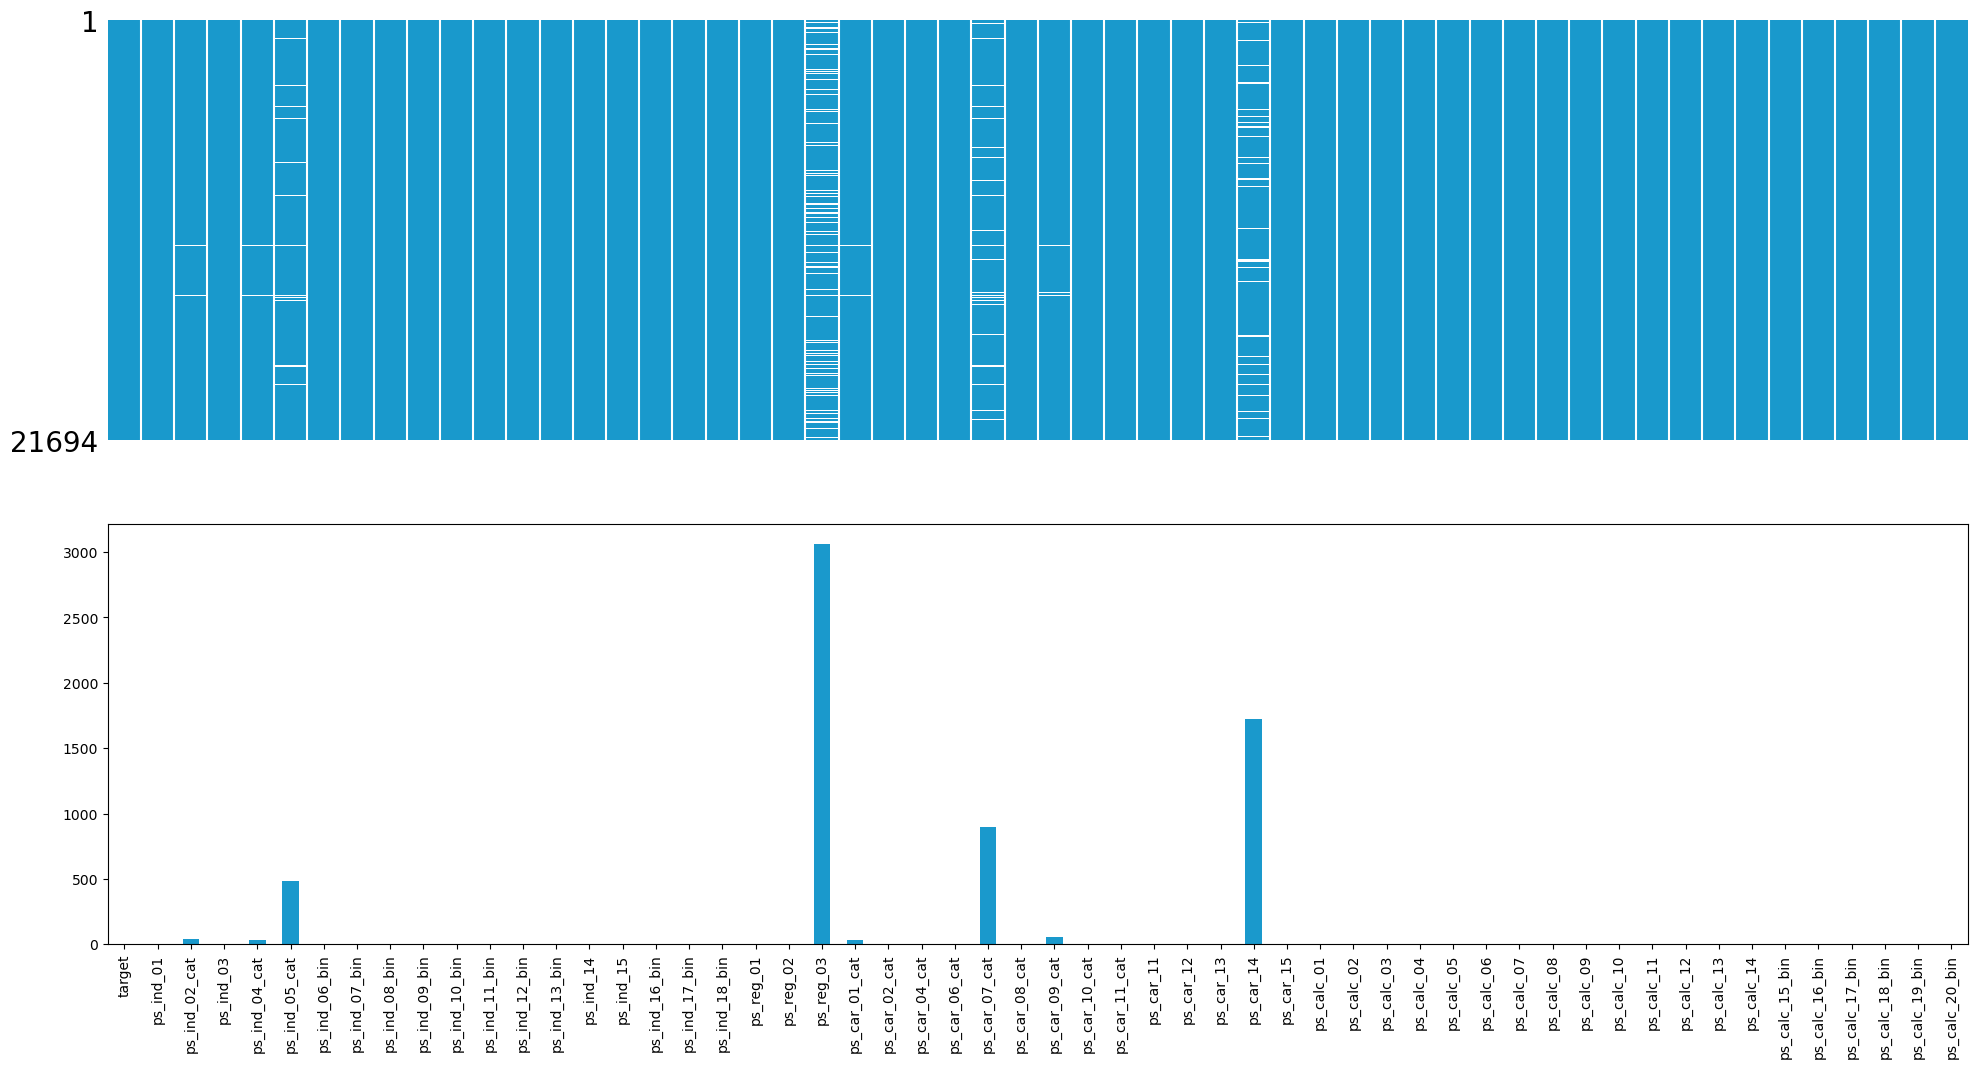

In [50]:
figure, axs = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(24,12)

msno.matrix(df=train_y1.iloc[:, :], color=(0.1, 0.6, 0.8),ax=axs[0])
train_y1.isna().sum().plot.bar(figsize = (24,12),color=(0.1, 0.6, 0.8))

/opt/conda/lib/python3.7/site-packages/missingno/missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  "Plotting a sparkline on an existing axis is not currently supported. "


<AxesSubplot:>

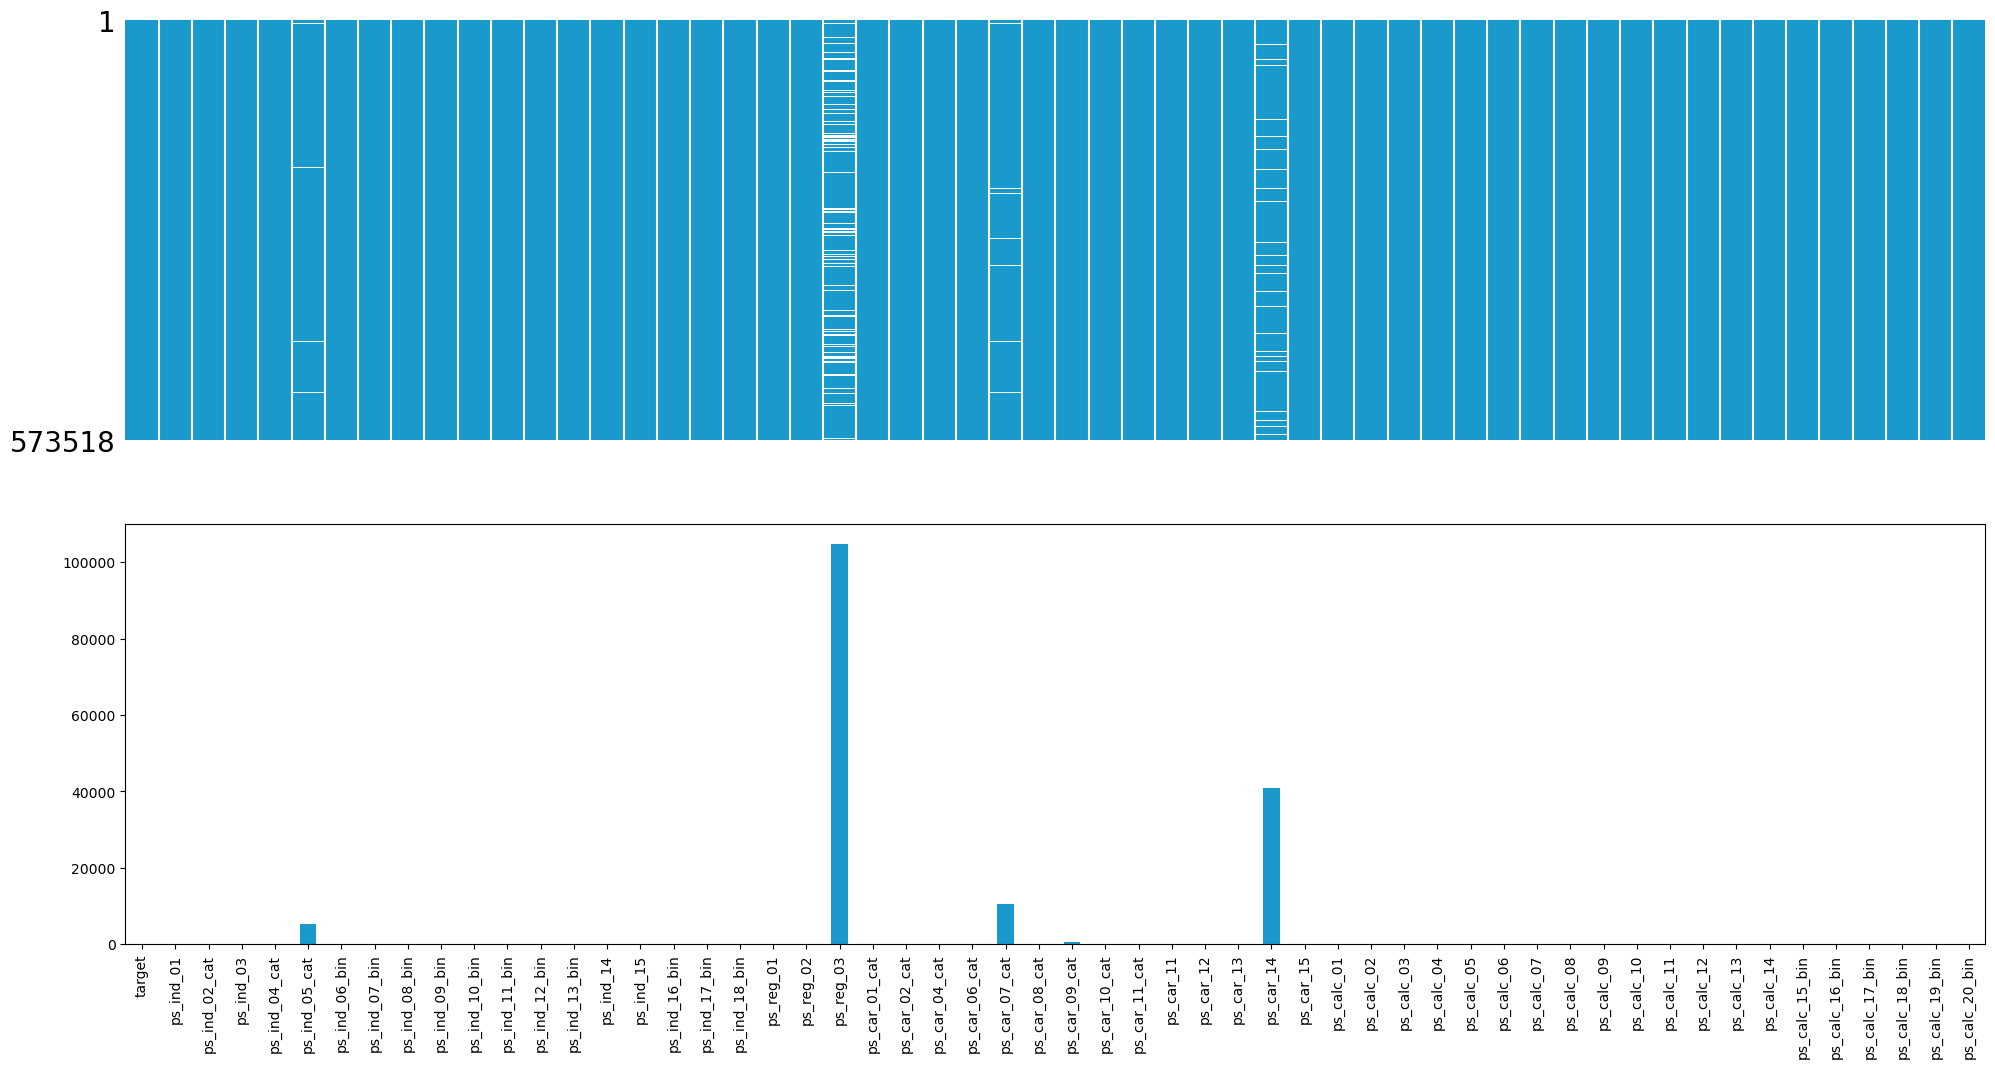

In [51]:
figure, axs = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(24,12)

msno.matrix(df=train_y0.iloc[:, :], color=(0.1, 0.6, 0.8),ax=axs[0])
train_y0.isna().sum().plot.bar(figsize = (24,12),color=(0.1, 0.6, 0.8))

정상치일 경우와 이상치일 경우 각 변수의 결측 비율이 유사함을 확인하였다. 이제 결측인 행과 결측이 아닌 행의 각 변수의 분포 차이를 파악해보겠다.  
먼저 변수타입별로 각 변수들을 구분해놓을 필요가 있다. 위에 언급한 데이터 설명을 참고하여 '\~bin'으로 끝나는 변수는 binary변수, '\~cat'으로 끝난다면 nominal categorical변수로 구분하고, 그 외의 변수들 중에서는 고유값이 100개 아래인 변수를 Ordinal변수로 구분하였다. 결과는 아래에 출력하였다. 

In [61]:
col_cat=[]
col_num=[]
col_bin=[]
col_ord=[]
for i in train.columns.to_list()[1:]:
    if '_cat' in i:
        col_cat.append(i)
    elif re.search('_bin',i):
        col_bin.append(i)
    elif train[i].nunique()>100:
        col_num.append(i)
    else:
        col_ord.append(i)
        
display(col_bin)
display(col_cat)
display(col_ord)
display(col_num)

['ps_ind_06_bin',
 'ps_ind_07_bin',
 'ps_ind_08_bin',
 'ps_ind_09_bin',
 'ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_12_bin',
 'ps_ind_13_bin',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin',
 'ps_calc_15_bin',
 'ps_calc_16_bin',
 'ps_calc_17_bin',
 'ps_calc_18_bin',
 'ps_calc_19_bin',
 'ps_calc_20_bin']

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_04_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

['ps_ind_01',
 'ps_ind_03',
 'ps_ind_14',
 'ps_ind_15',
 'ps_reg_01',
 'ps_reg_02',
 'ps_car_11',
 'ps_car_15',
 'ps_calc_01',
 'ps_calc_02',
 'ps_calc_03',
 'ps_calc_04',
 'ps_calc_05',
 'ps_calc_06',
 'ps_calc_07',
 'ps_calc_08',
 'ps_calc_09',
 'ps_calc_10',
 'ps_calc_11',
 'ps_calc_12',
 'ps_calc_13',
 'ps_calc_14']

['ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_14']

분포 차이 파악 - binary변수

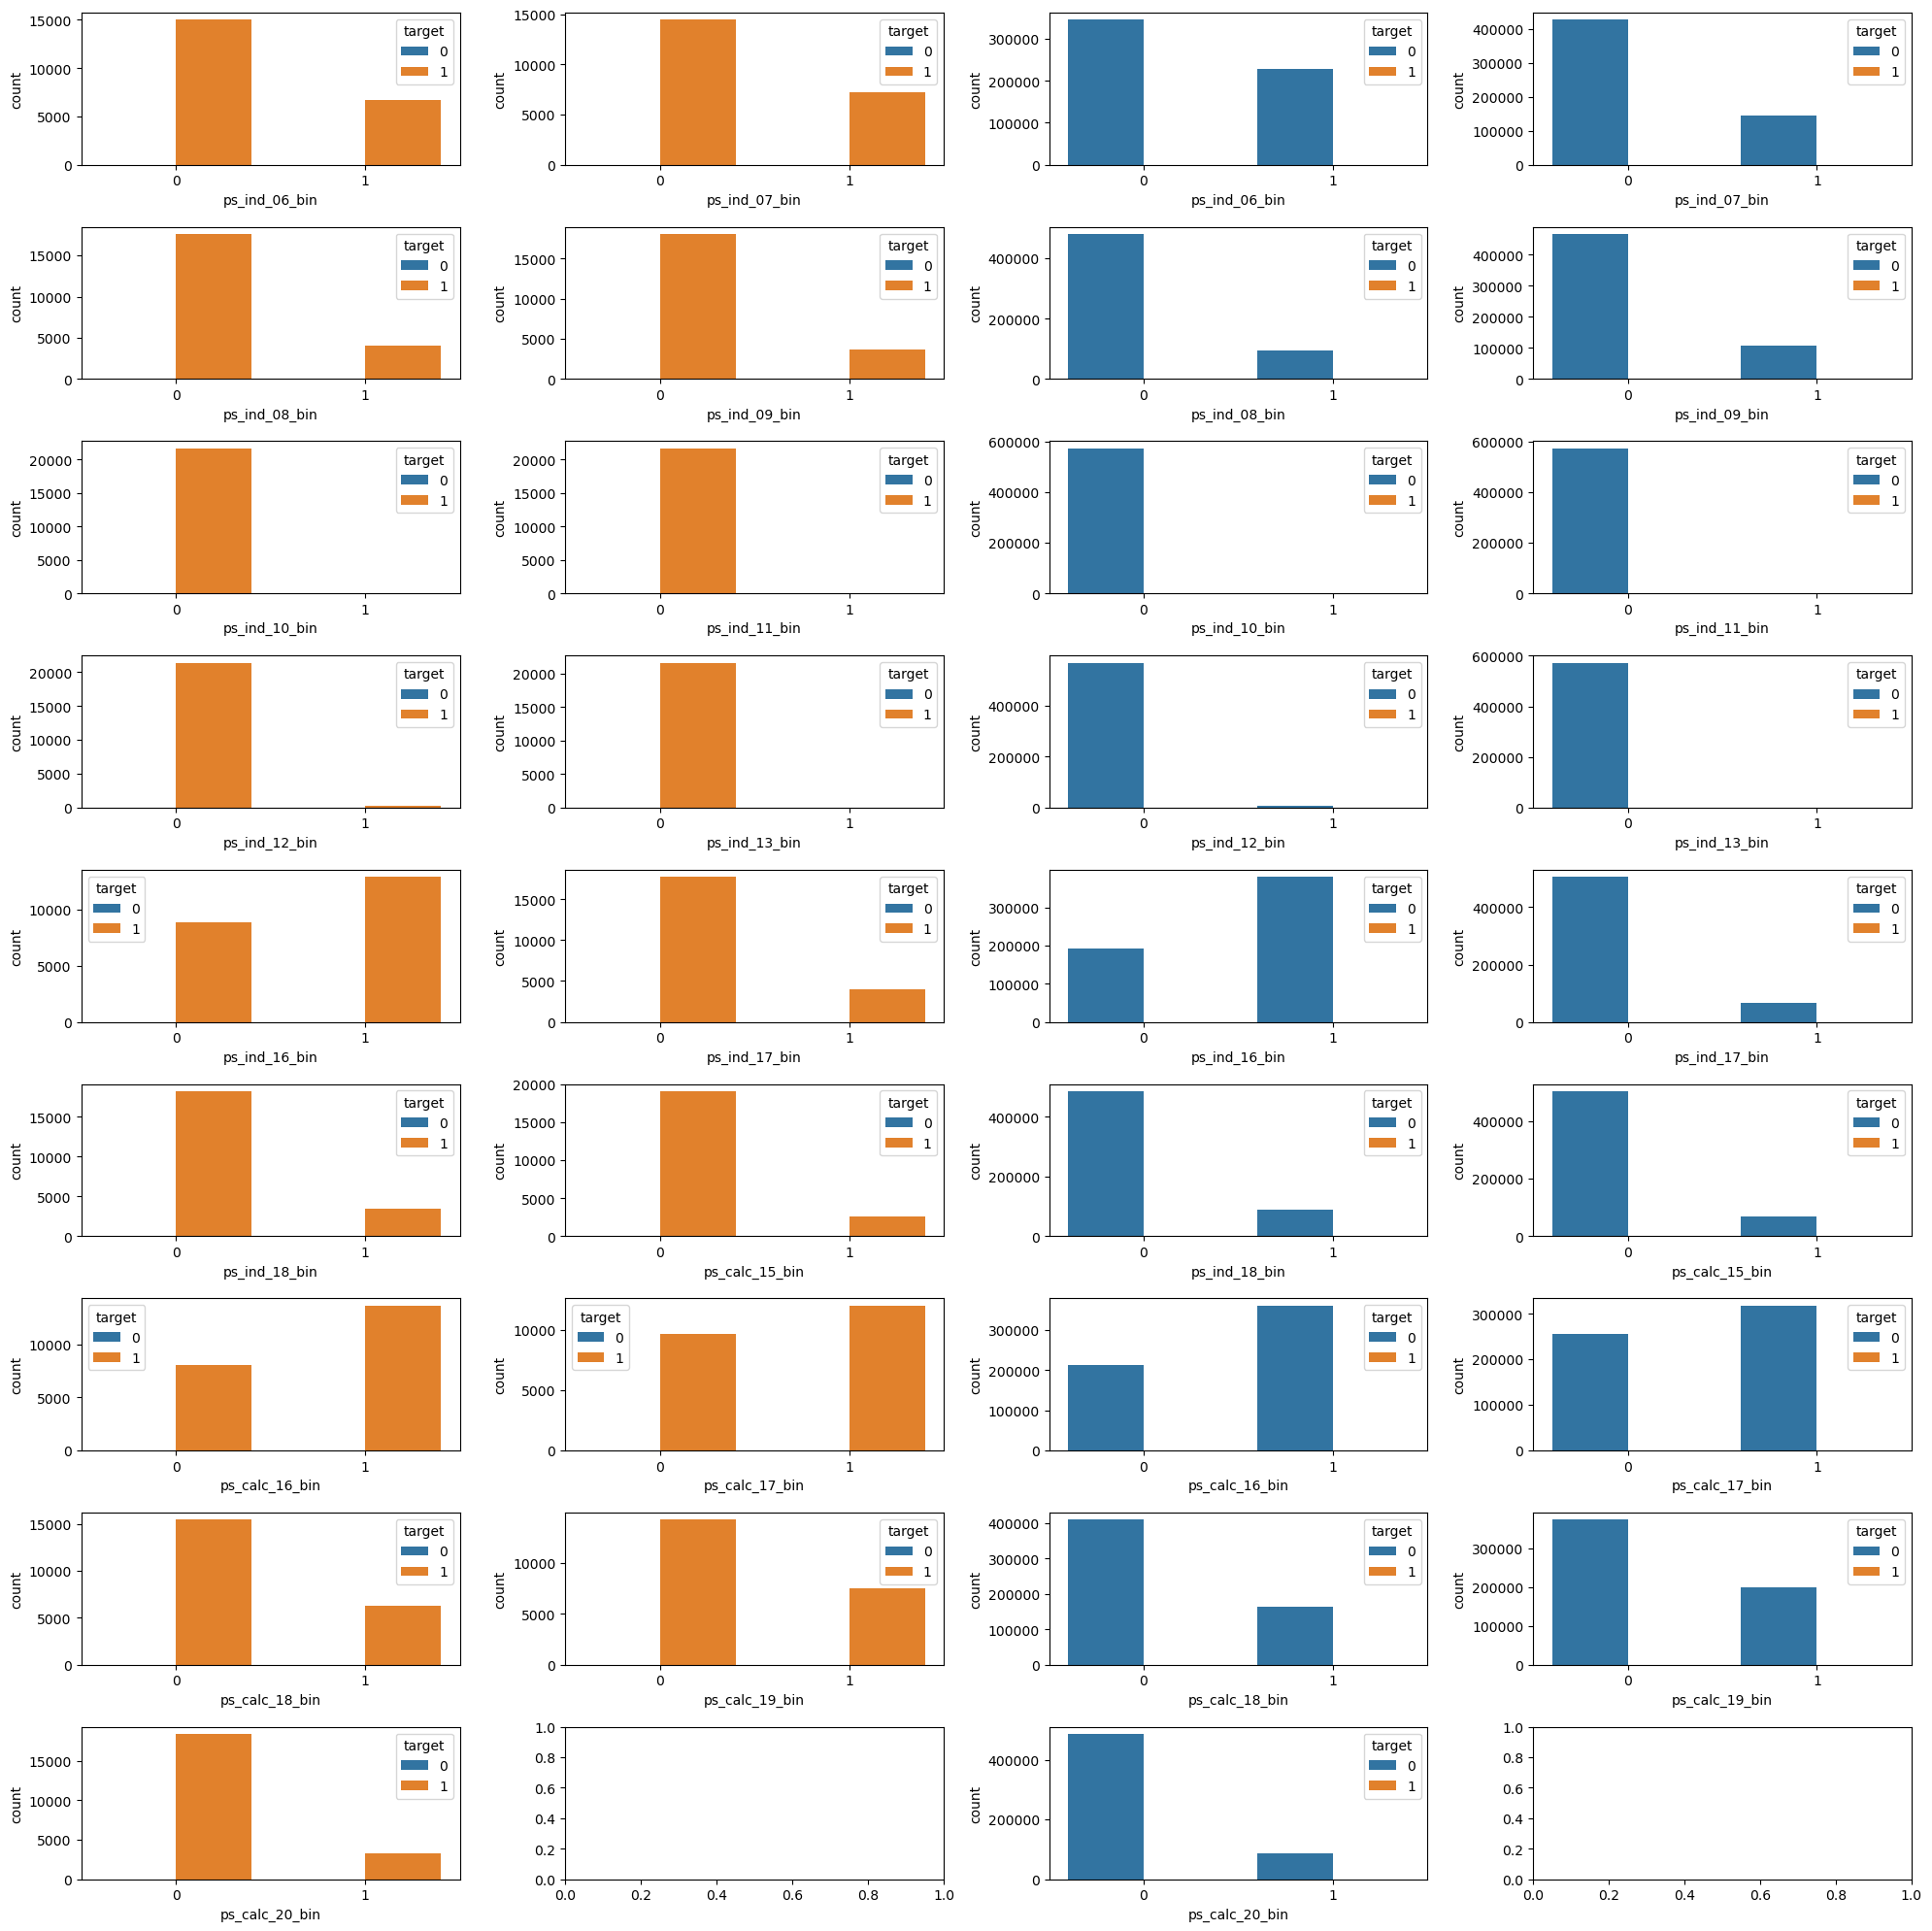

In [64]:
figure, axs = plt.subplots(nrows=(len(col_bin)//2)+1, ncols=4)
figure.set_size_inches(20,20)

for i, col in enumerate(train_y1[col_bin]):
    sns.countplot(x=train_y1[col],hue=train['target'],ax=axs[i//2,i%2])
    sns.countplot(x=train_y0[col],hue=train['target'],ax=axs[i//2,i%2+2])
figure.tight_layout() 

분포 차이 파악 - categorical변수

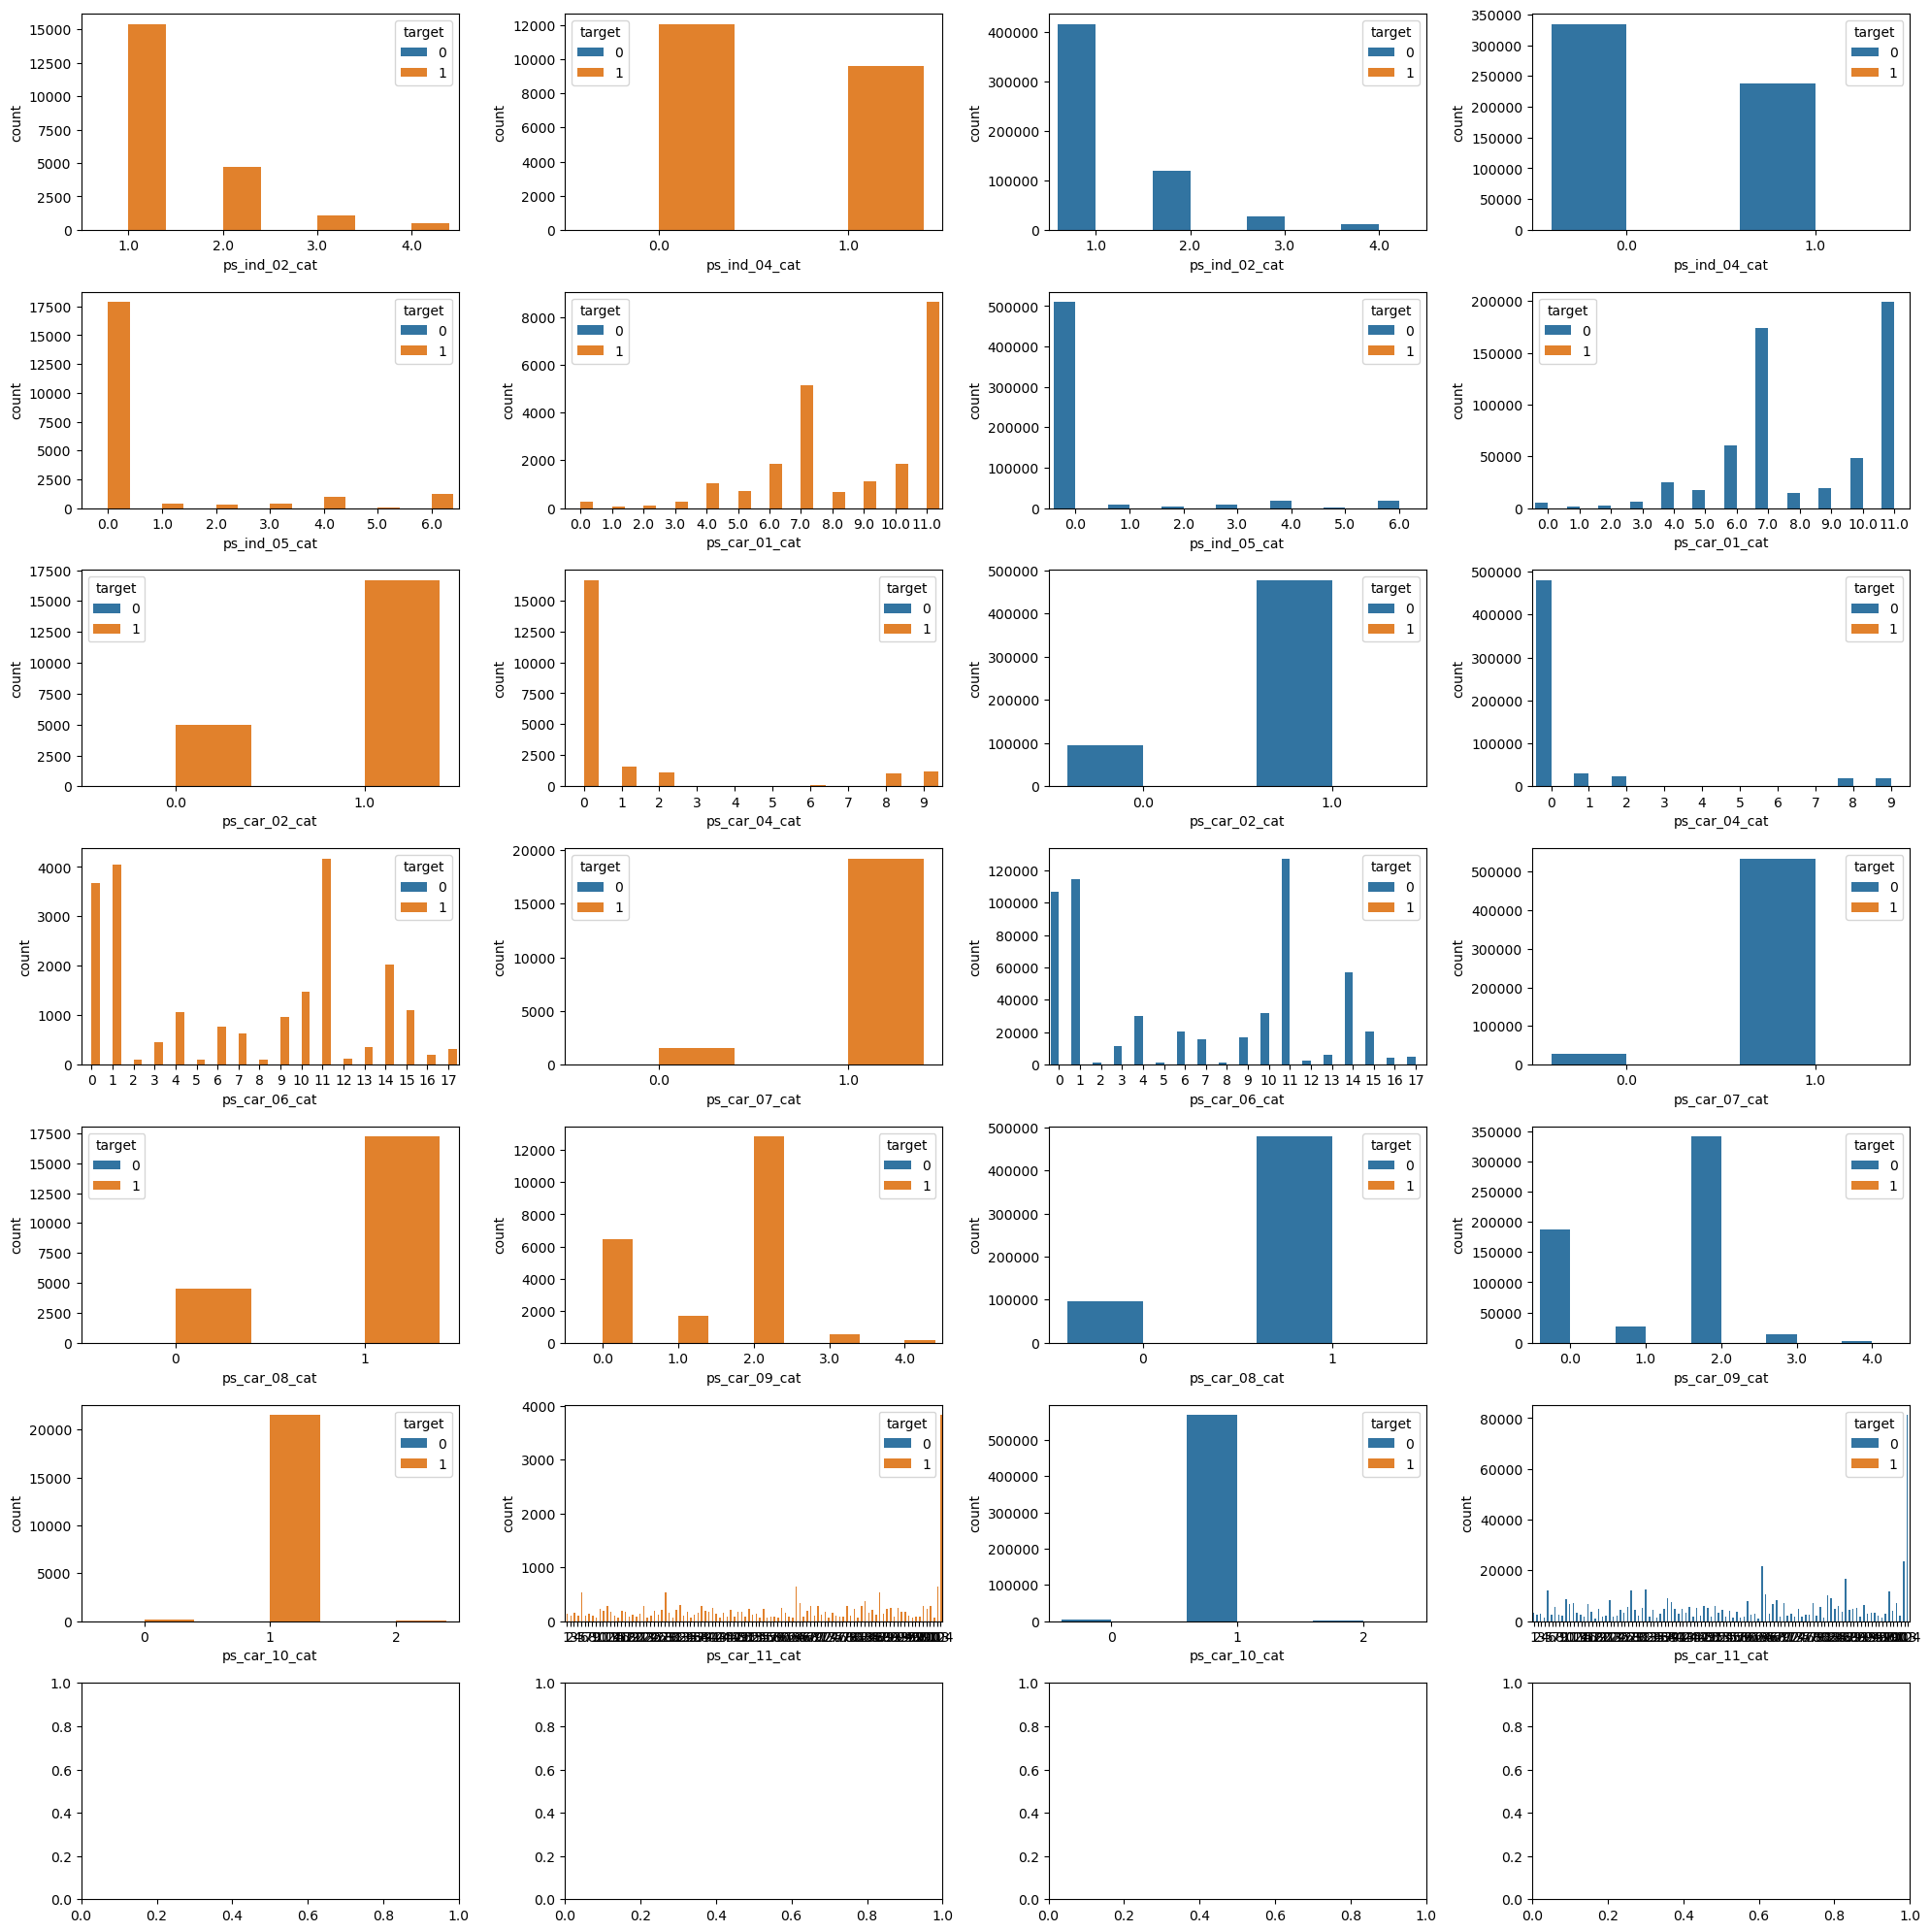

In [63]:
figure, axs = plt.subplots(nrows=(len(col_cat)//2)+1, ncols=4)
figure.set_size_inches(20,20)

for i, col in enumerate(train_y1[col_cat]):
    sns.countplot(x=train_y1[col],hue=train['target'],ax=axs[i//2,i%2])
    sns.countplot(x=train_y0[col],hue=train['target'],ax=axs[i//2,i%2+2])
figure.tight_layout() 

분포 차이 파악 - ordinal변수

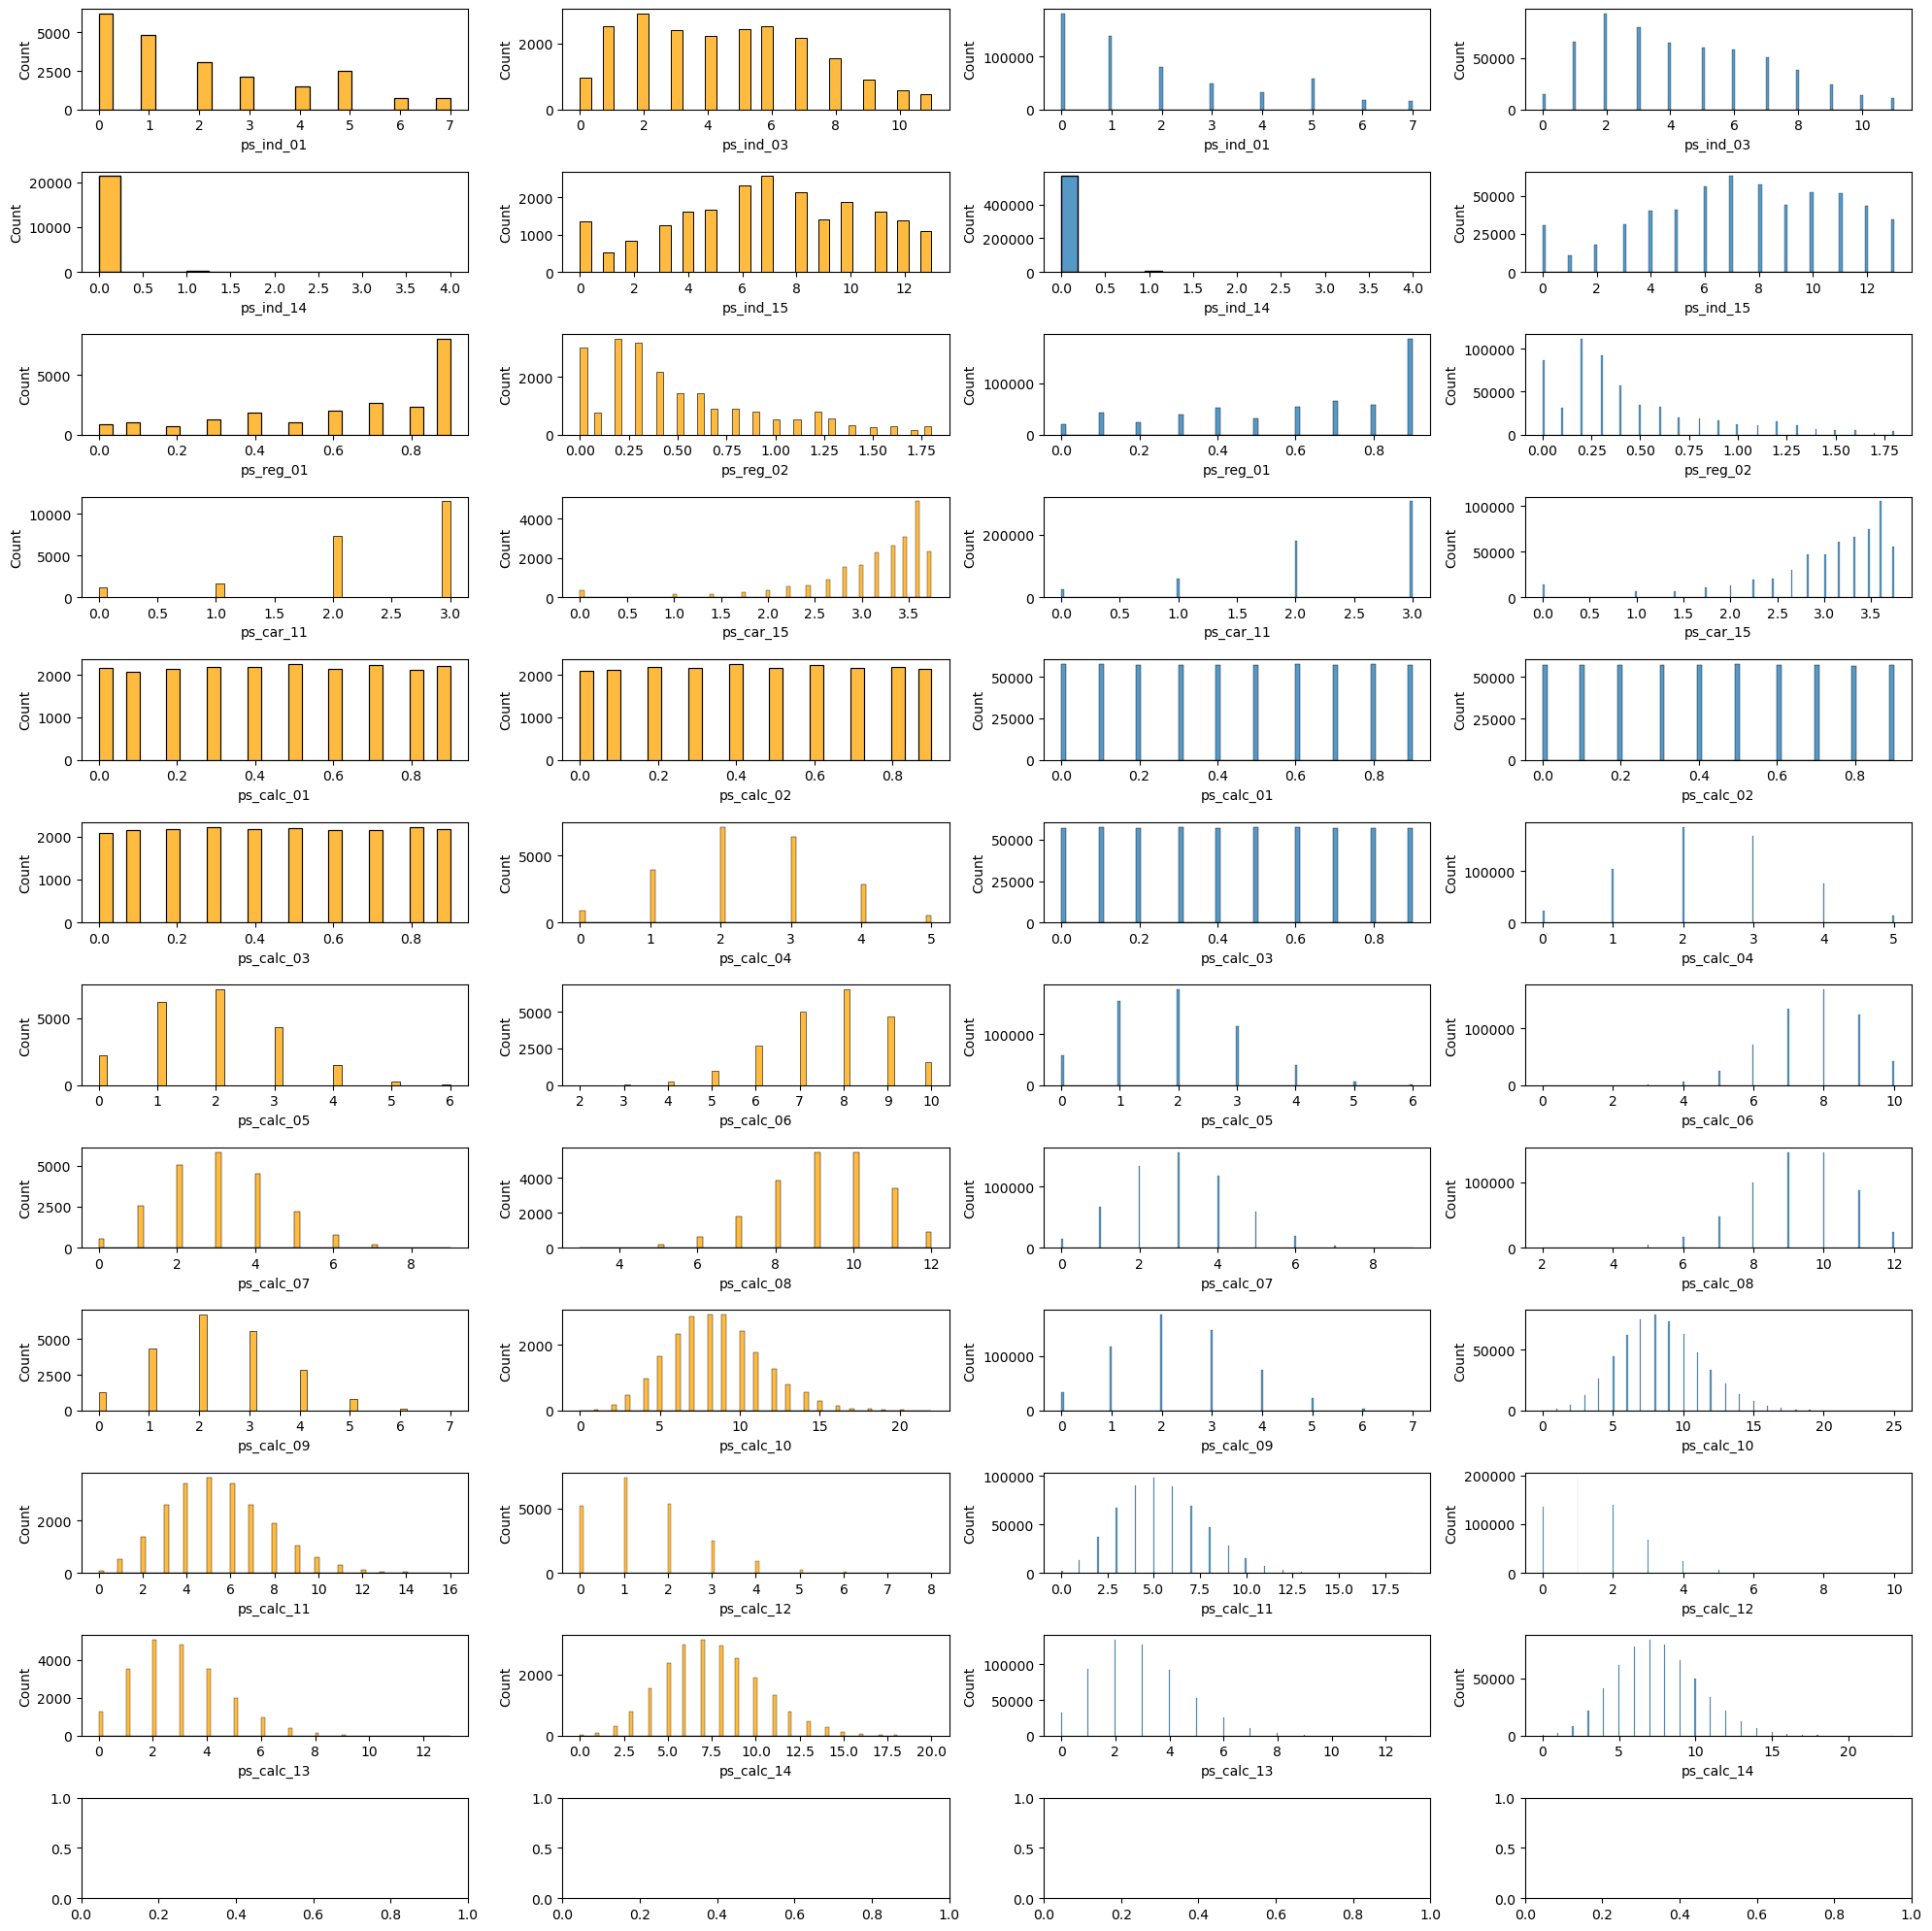

In [65]:
figure, axs = plt.subplots(nrows=(len(col_ord)//2)+1, ncols=4)
figure.set_size_inches(20,20)

for i, col in enumerate(train_y1[col_ord]):
    sns.histplot(train_y1, x=col,color='orange',ax=axs[i//2,i%2])
    sns.histplot(train_y0, x=col,ax=axs[i//2,i%2+2])
figure.tight_layout() 

분포 차이 파악 - numerical변수

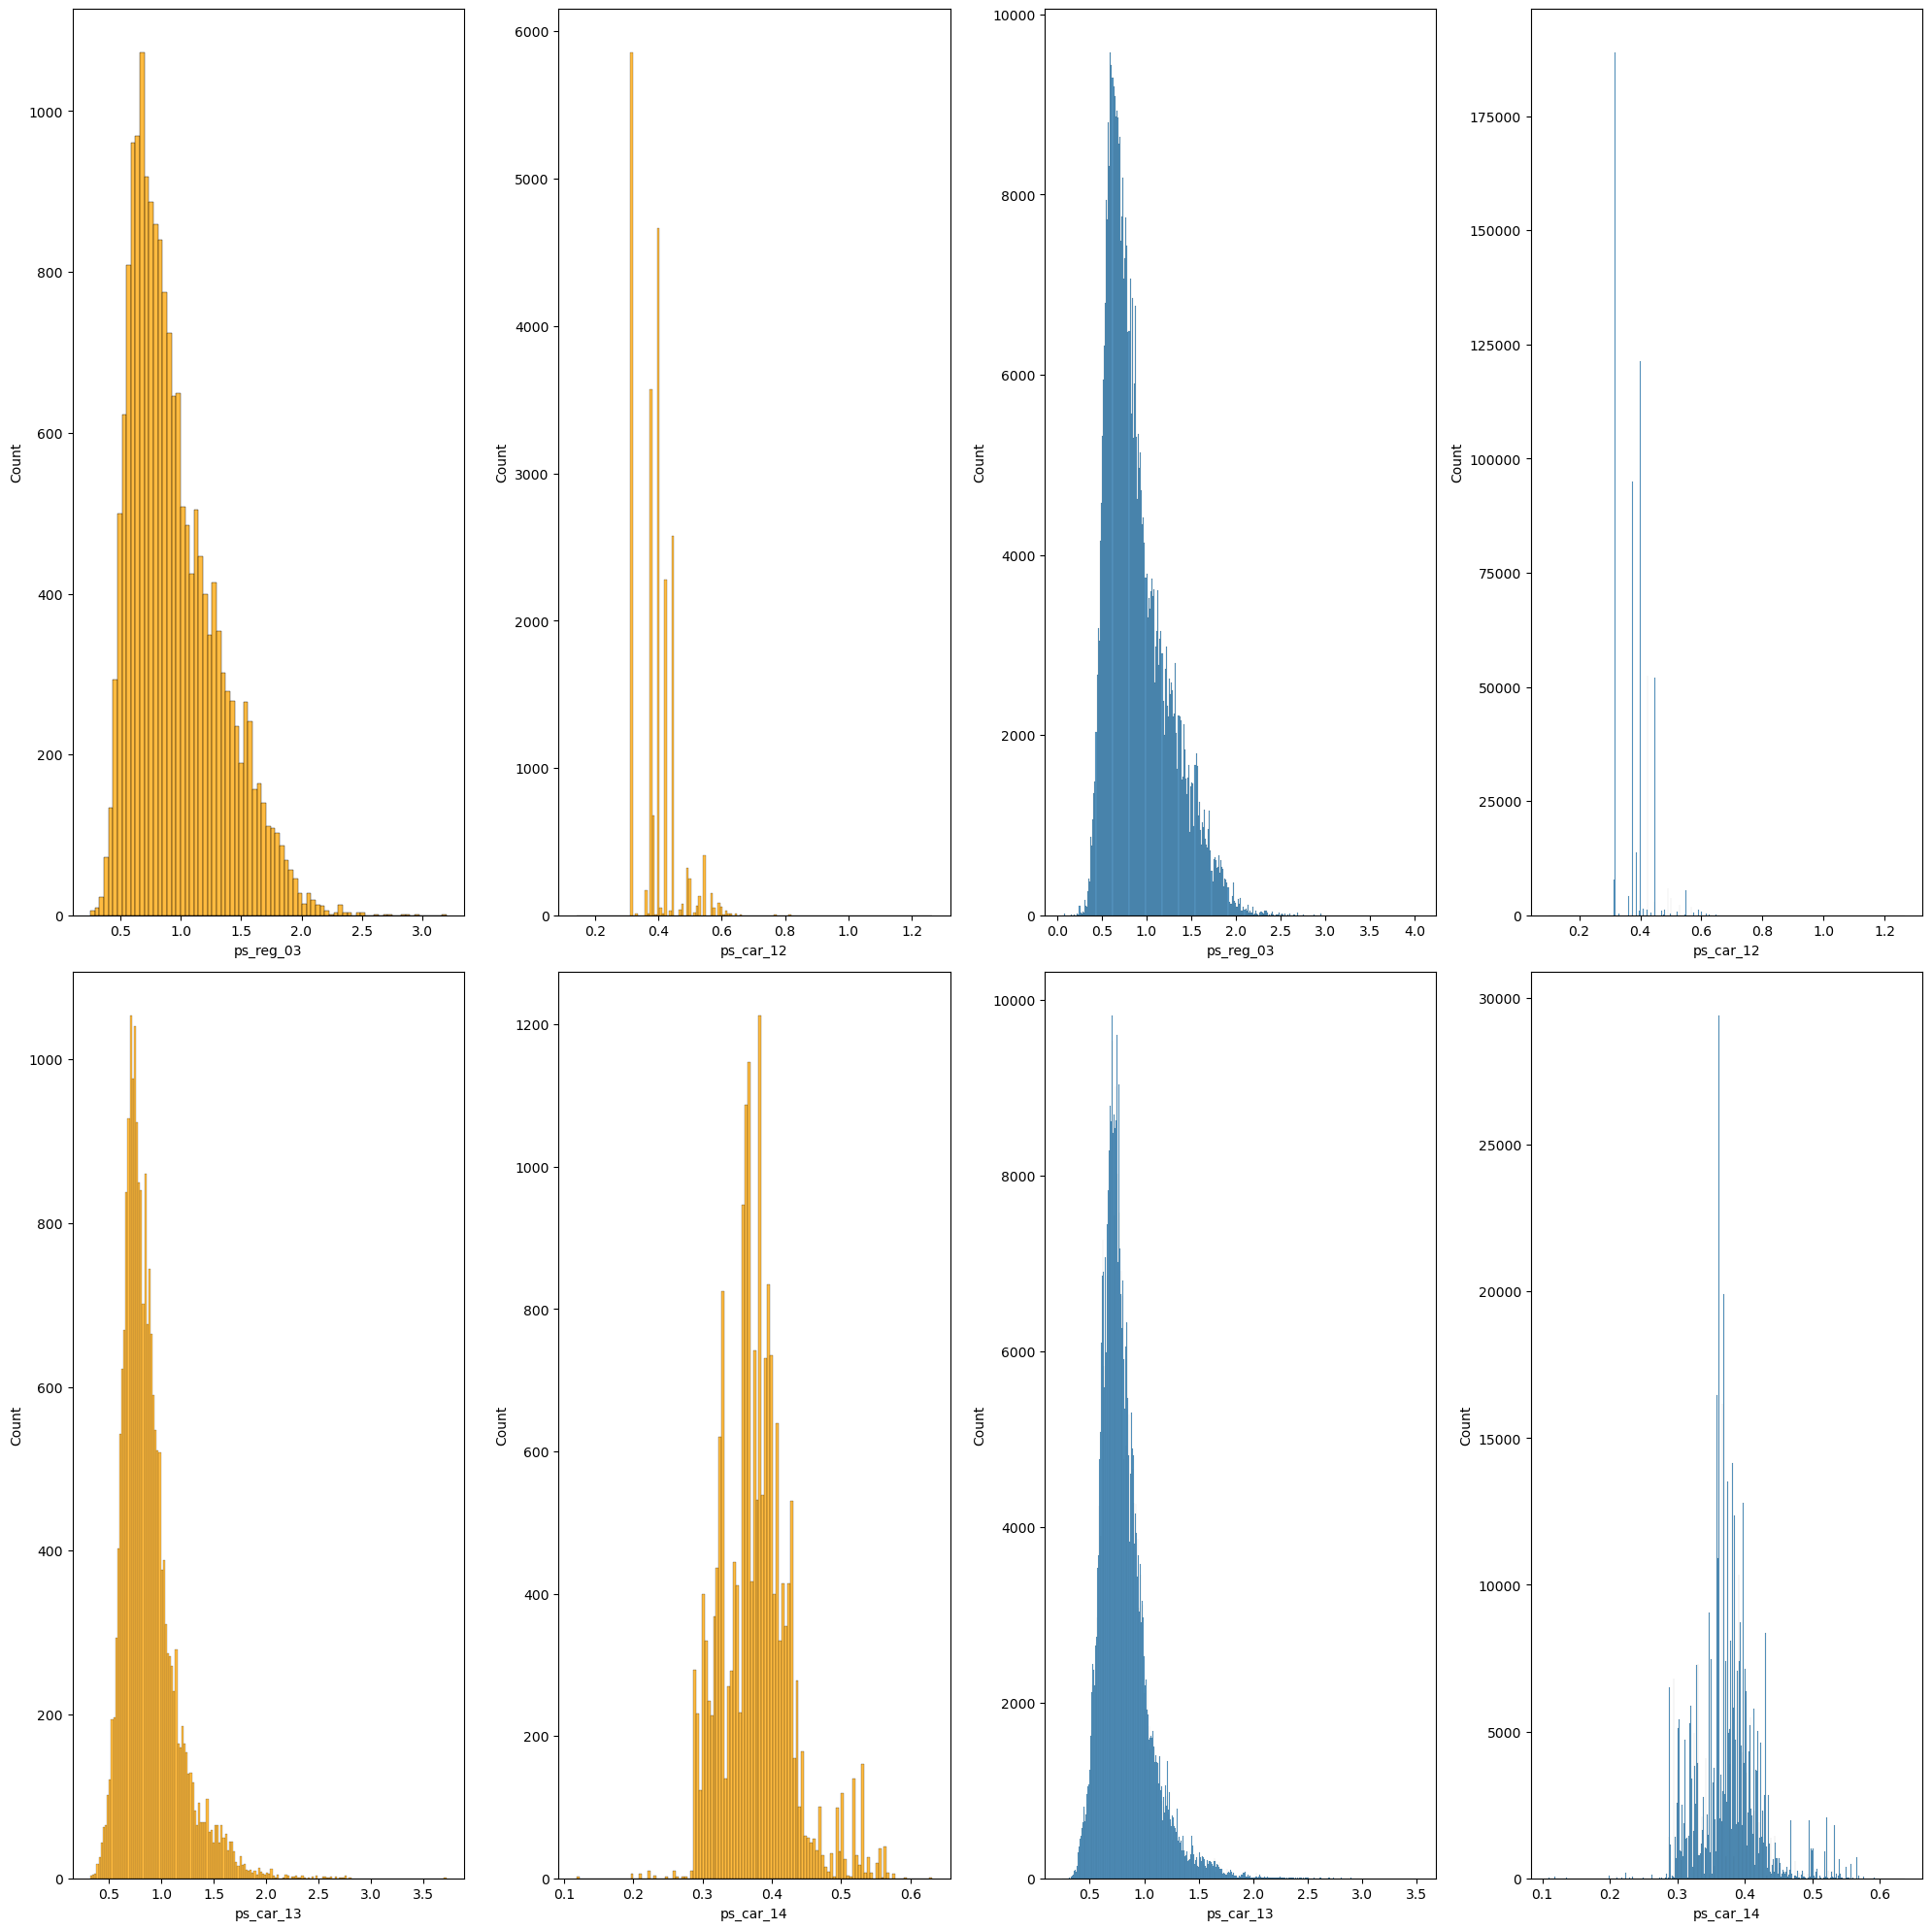

In [66]:
figure, axs = plt.subplots(nrows=(len(col_num)//2), ncols=4)
figure.set_size_inches(20,20)

for i, col in enumerate(train_y1[col_num]):
    sns.histplot(train_y1, x=col,color='orange',ax=axs[i//2,i%2])
    sns.histplot(train_y0, x=col,ax=axs[i//2,i%2+2])
figure.tight_layout() 

전체적으로 분포가 y값에 독립적으로 유사한 것을 확인하였다. 이에 더하여 사전에 파악한 결과들과 함께 통합적으로 고려해본 결과 MCAR일 것으로 추정된다.  
본격적인 결측치 대체 전에 이에 활용할 수 있는 변수를 판별하기 위해 상관분석을 실시하였다. 연속형 변수는 Pearson's correlation을 사용하였고, 이 외의 데이터들은 Cramer's V를 사용하여 상관관계를 알아보았다. 

In [67]:
def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    return (stat/(obs*mini))

In [68]:
rows= []

for var1 in train[col_bin]:
    col = []
    for var2 in train[col_bin]:
        cramers =cramers_V(train[col_bin][var1], train[col_bin][var2]) # Cramer's V test
        col.append(round(cramers,4)) # Keeping of the rounded value of the Cramer's V  
    rows.append(col)
cramers_results = np.array(rows)
corr_bin = pd.DataFrame(cramers_results, columns =train[col_bin].columns, index =train[col_bin].columns)

In [69]:
rows= []

for var1 in train[col_ord]:
    col = []
    for var2 in train[col_ord]:
        cramers =cramers_V(train[col_ord][var1], train[col_ord][var2]) # Cramer's V test
        col.append(round(cramers,4)) # Keeping of the rounded value of the Cramer's V  
    rows.append(col)
cramers_results = np.array(rows)
corr_ord = pd.DataFrame(cramers_results, columns =train[col_ord].columns, index =train[col_ord].columns)

In [71]:
rows= []

for var1 in train[col_cat]:
    col = []
    for var2 in train[col_cat]:
        cramers =cramers_V(train[col_cat][var1], train[col_cat][var2]) # Cramer's V test
        col.append(round(cramers,4)) # Keeping of the rounded value of the Cramer's V  
    rows.append(col)
cramers_results = np.array(rows)
corr_cat = pd.DataFrame(cramers_results, columns =train[col_cat].columns, index =train[col_cat].columns)

<AxesSubplot:>

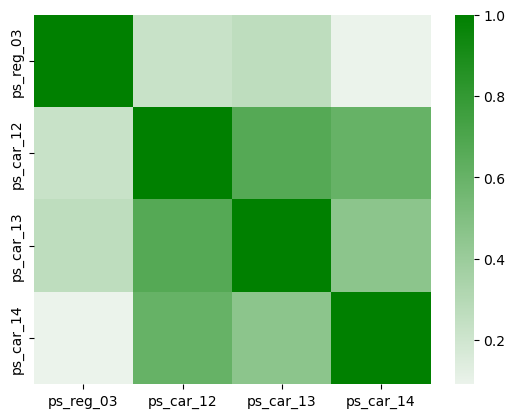

In [72]:
corr_num=train[col_num].corr(method='pearson')
sns.heatmap(corr_num, annot=False, cmap=sns.light_palette("green", as_cmap=True))

<AxesSubplot:>

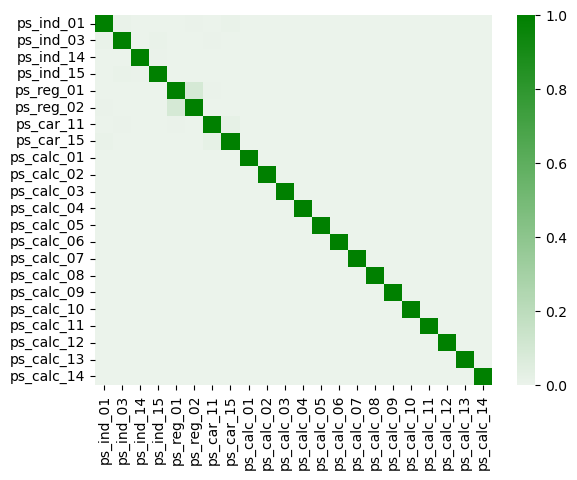

In [73]:
sns.heatmap(corr_ord, annot=False, cmap=sns.light_palette("green", as_cmap=True))

<AxesSubplot:>

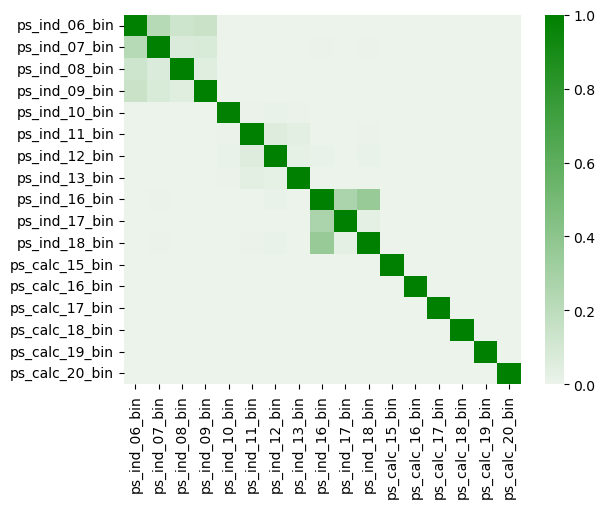

In [74]:
sns.heatmap(corr_bin, annot=False, cmap=sns.light_palette("green", as_cmap=True))

<AxesSubplot:>

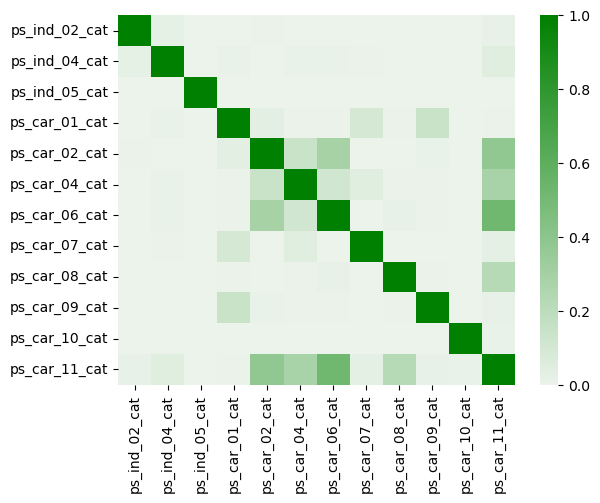

In [75]:
sns.heatmap(corr_cat, annot=False, cmap=sns.light_palette("green", as_cmap=True))

상관관계 분석 결과 연속형 변수를 제외하면 같은 유형의 변수들 간 상관관계가 낮은 모습을 확인하였다.  
연속형 자료끼리는 상관관계를 보이므로 Linear Model을 사용하여 보간해주고, 순서형, 범주형 자료는 상관관계가 낮기 때문에 Non-Linear한 방법을 사용해주는 것이 적절해 보인다.  
연속형 자료를 보간하기 위해서 Scikit-learn에서 진행한 결측치 보간 예제 비교 중 가장 좋은 성능을 보였던 BayesianRidge를 사용할 것이고, 순서형, 범주형 자료는 RandomForestClassifier를 통해 보간하여 변수들이 가지는 특성을 최대한 보존할 수 있도록 할 것이다. 

In [76]:
imp_num = IterativeImputer(estimator=BayesianRidge(),max_iter=10, random_state=1111,verbose=True)
imp_cat = IterativeImputer(estimator=RandomForestClassifier(n_estimators=40,
                           max_depth=10,
                           bootstrap=True,
                           max_samples=0.5,
                           n_jobs=2),
                           initial_strategy='most_frequent',
                           max_iter=10, random_state=1111,verbose=True)
imp_ord = IterativeImputer(estimator=RandomForestClassifier(n_estimators=40,
                           max_depth=10,
                           bootstrap=True,
                           max_samples=0.5,
                           n_jobs=2),
                           initial_strategy='most_frequent',
                           max_iter=10, random_state=1111,verbose=True)

In [77]:
imp_num=imp_num.fit(train[col_num])

[IterativeImputer] Completing matrix with shape (595212, 4)
[IterativeImputer] Change: 1.105578207344677, scaled tolerance: 0.004037945021899999 
[IterativeImputer] Change: 0.010276454663246892, scaled tolerance: 0.004037945021899999 
[IterativeImputer] Change: 6.419542510793796e-05, scaled tolerance: 0.004037945021899999 
[IterativeImputer] Early stopping criterion reached.


In [79]:
imp_cat=imp_cat.fit(train[col_cat])

[IterativeImputer] Completing matrix with shape (595212, 12)
[IterativeImputer] Change: 7.0, scaled tolerance: 0.10400000000000001 
[IterativeImputer] Change: 4.0, scaled tolerance: 0.10400000000000001 
[IterativeImputer] Change: 4.0, scaled tolerance: 0.10400000000000001 
[IterativeImputer] Change: 5.0, scaled tolerance: 0.10400000000000001 
[IterativeImputer] Change: 4.0, scaled tolerance: 0.10400000000000001 
[IterativeImputer] Change: 5.0, scaled tolerance: 0.10400000000000001 
[IterativeImputer] Change: 4.0, scaled tolerance: 0.10400000000000001 


KeyboardInterrupt: 

In [83]:
train[col_ord] = train[col_ord].fillna(0).astype(np.int64, errors='ignore').replace({-1: np.nan})
imp_ord=imp_ord.fit(train[col_ord])

[IterativeImputer] Completing matrix with shape (595212, 22)
[IterativeImputer] Change: 0.0, scaled tolerance: 0.025 
[IterativeImputer] Early stopping criterion reached.


In [84]:
imp_num_train=imp_num.transform(train[col_num])
imp_cat_train=imp_cat.transform(train[col_cat])
imp_ord_train=imp_ord.transform(train[col_ord])

x_train_num = pd.DataFrame(imp_num_train, columns=train[col_num].columns)
x_train_cat = pd.DataFrame(imp_cat_train, columns=train[col_cat].columns)
x_train_ord = pd.DataFrame(imp_ord_train, columns=train[col_ord].columns)

[IterativeImputer] Completing matrix with shape (595212, 4)
[IterativeImputer] Completing matrix with shape (595212, 12)
[IterativeImputer] Completing matrix with shape (595212, 22)


In [85]:
train_ii = pd.concat([train['target'],x_train_num,x_train_cat,x_train_ord,train[col_bin]],axis=1)

In [87]:
train_ii[col_cat]=train_ii[col_cat].astype(pd.Int64Dtype())
train_ii[col_ord]=train_ii[col_ord].astype(pd.Int64Dtype())

In [88]:
train_ii.dtypes

target              int64
ps_reg_03         float64
ps_car_12         float64
ps_car_13         float64
ps_car_14         float64
ps_ind_02_cat       Int64
ps_ind_04_cat       Int64
ps_ind_05_cat       Int64
ps_car_01_cat       Int64
ps_car_02_cat       Int64
ps_car_04_cat       Int64
ps_car_06_cat       Int64
ps_car_07_cat       Int64
ps_car_08_cat       Int64
ps_car_09_cat       Int64
ps_car_10_cat       Int64
ps_car_11_cat       Int64
ps_ind_01           Int64
ps_ind_03           Int64
ps_ind_14           Int64
ps_ind_15           Int64
ps_reg_01           Int64
ps_reg_02           Int64
ps_car_11           Int64
ps_car_15           Int64
ps_calc_01          Int64
ps_calc_02          Int64
ps_calc_03          Int64
ps_calc_04          Int64
ps_calc_05          Int64
ps_calc_06          Int64
ps_calc_07          Int64
ps_calc_08          Int64
ps_calc_09          Int64
ps_calc_10          Int64
ps_calc_11          Int64
ps_calc_12          Int64
ps_calc_13          Int64
ps_calc_14  

In [90]:
train_ii.isna().sum()

target            0
ps_reg_03         0
ps_car_12         0
ps_car_13         0
ps_car_14         0
ps_ind_02_cat     0
ps_ind_04_cat     0
ps_ind_05_cat     0
ps_car_01_cat     0
ps_car_02_cat     0
ps_car_04_cat     0
ps_car_06_cat     0
ps_car_07_cat     0
ps_car_08_cat     0
ps_car_09_cat     0
ps_car_10_cat     0
ps_car_11_cat     0
ps_ind_01         0
ps_ind_03         0
ps_ind_14         0
ps_ind_15         0
ps_reg_01         0
ps_reg_02         0
ps_car_11         0
ps_car_15         0
ps_calc_01        0
ps_calc_02        0
ps_calc_03        0
ps_calc_04        0
ps_calc_05        0
ps_calc_06        0
ps_calc_07        0
ps_calc_08        0
ps_calc_09        0
ps_calc_10        0
ps_calc_11        0
ps_calc_12        0
ps_calc_13        0
ps_calc_14        0
ps_ind_06_bin     0
ps_ind_07_bin     0
ps_ind_08_bin     0
ps_ind_09_bin     0
ps_ind_10_bin     0
ps_ind_11_bin     0
ps_ind_12_bin     0
ps_ind_13_bin     0
ps_ind_16_bin     0
ps_ind_17_bin     0
ps_ind_18_bin     0


결측치가 모두 대체되었음을 확인하였다. 

In [91]:
train_y1_ii=train_ii[train_ii['target']==1]
train_y0_ii=train_ii[train_ii['target']==0]

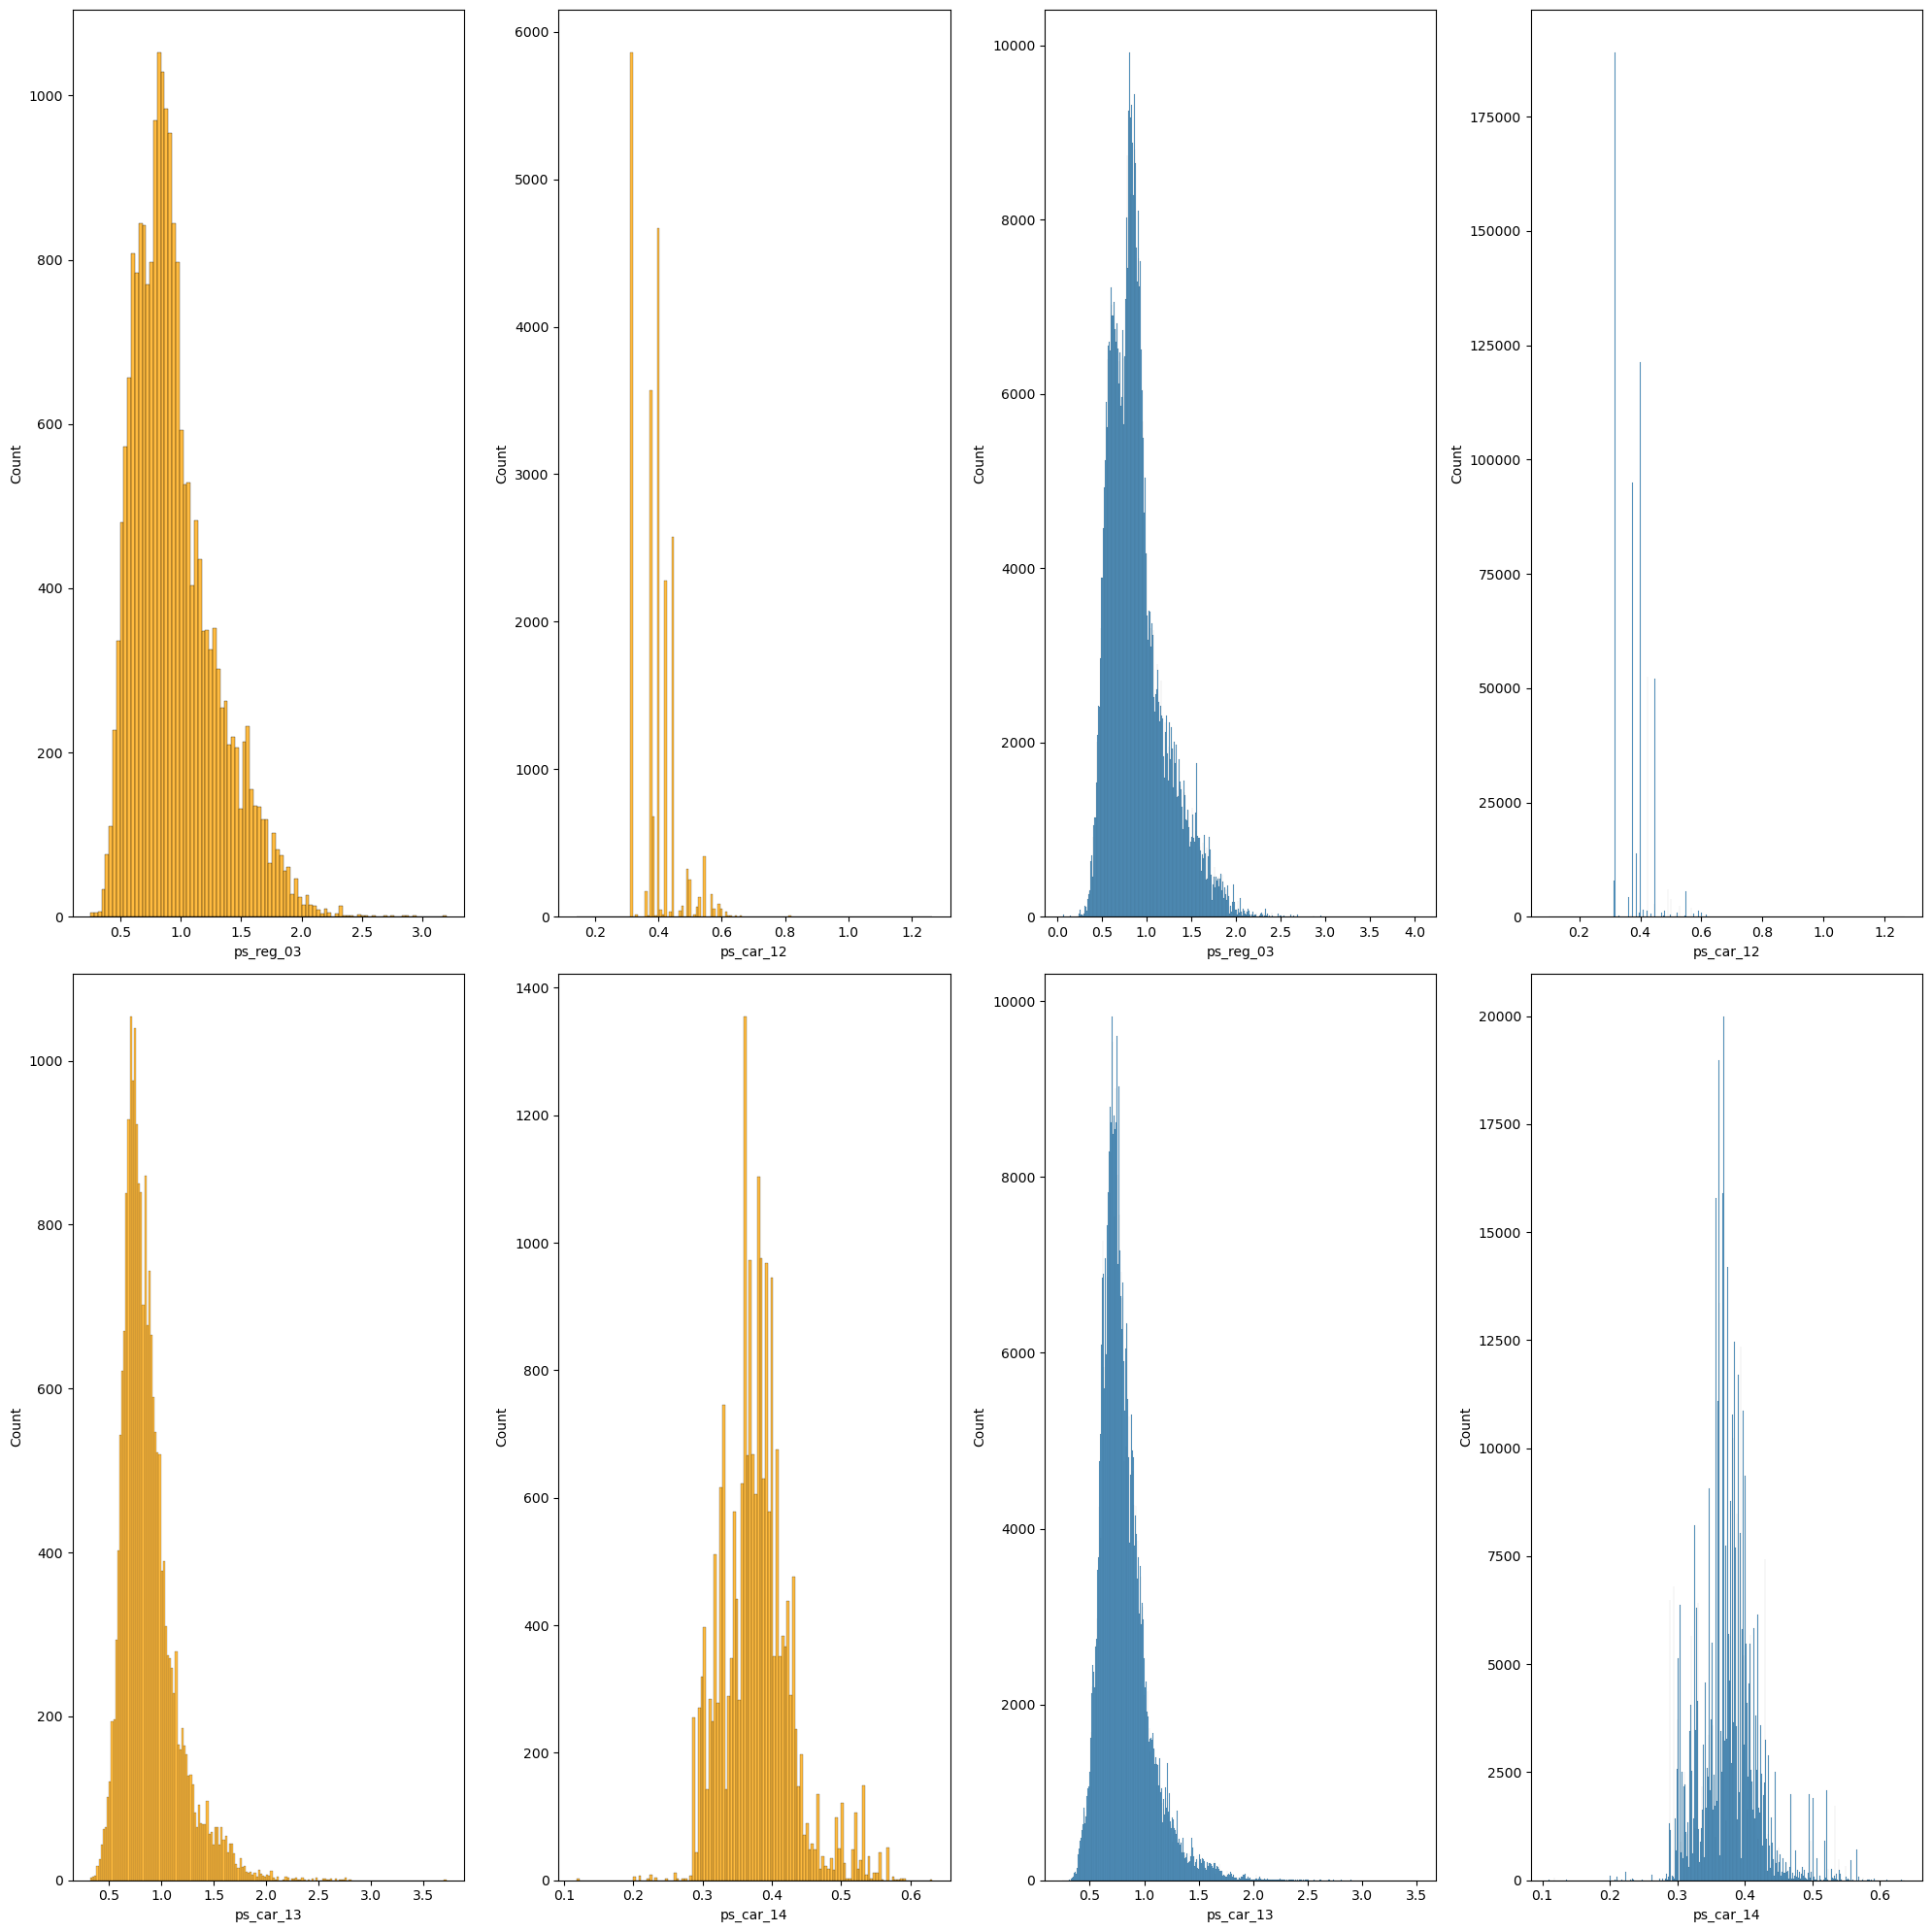

In [92]:
figure, axs = plt.subplots(nrows=(len(col_num)//2), ncols=4)
figure.set_size_inches(20,20)

for i, col in enumerate(train_y1_ii[col_num]):
    sns.histplot(train_y1_ii, x=col,color='orange',ax=axs[i//2,i%2])
    sns.histplot(train_y0_ii, x=col,ax=axs[i//2,i%2+2])
figure.tight_layout() 

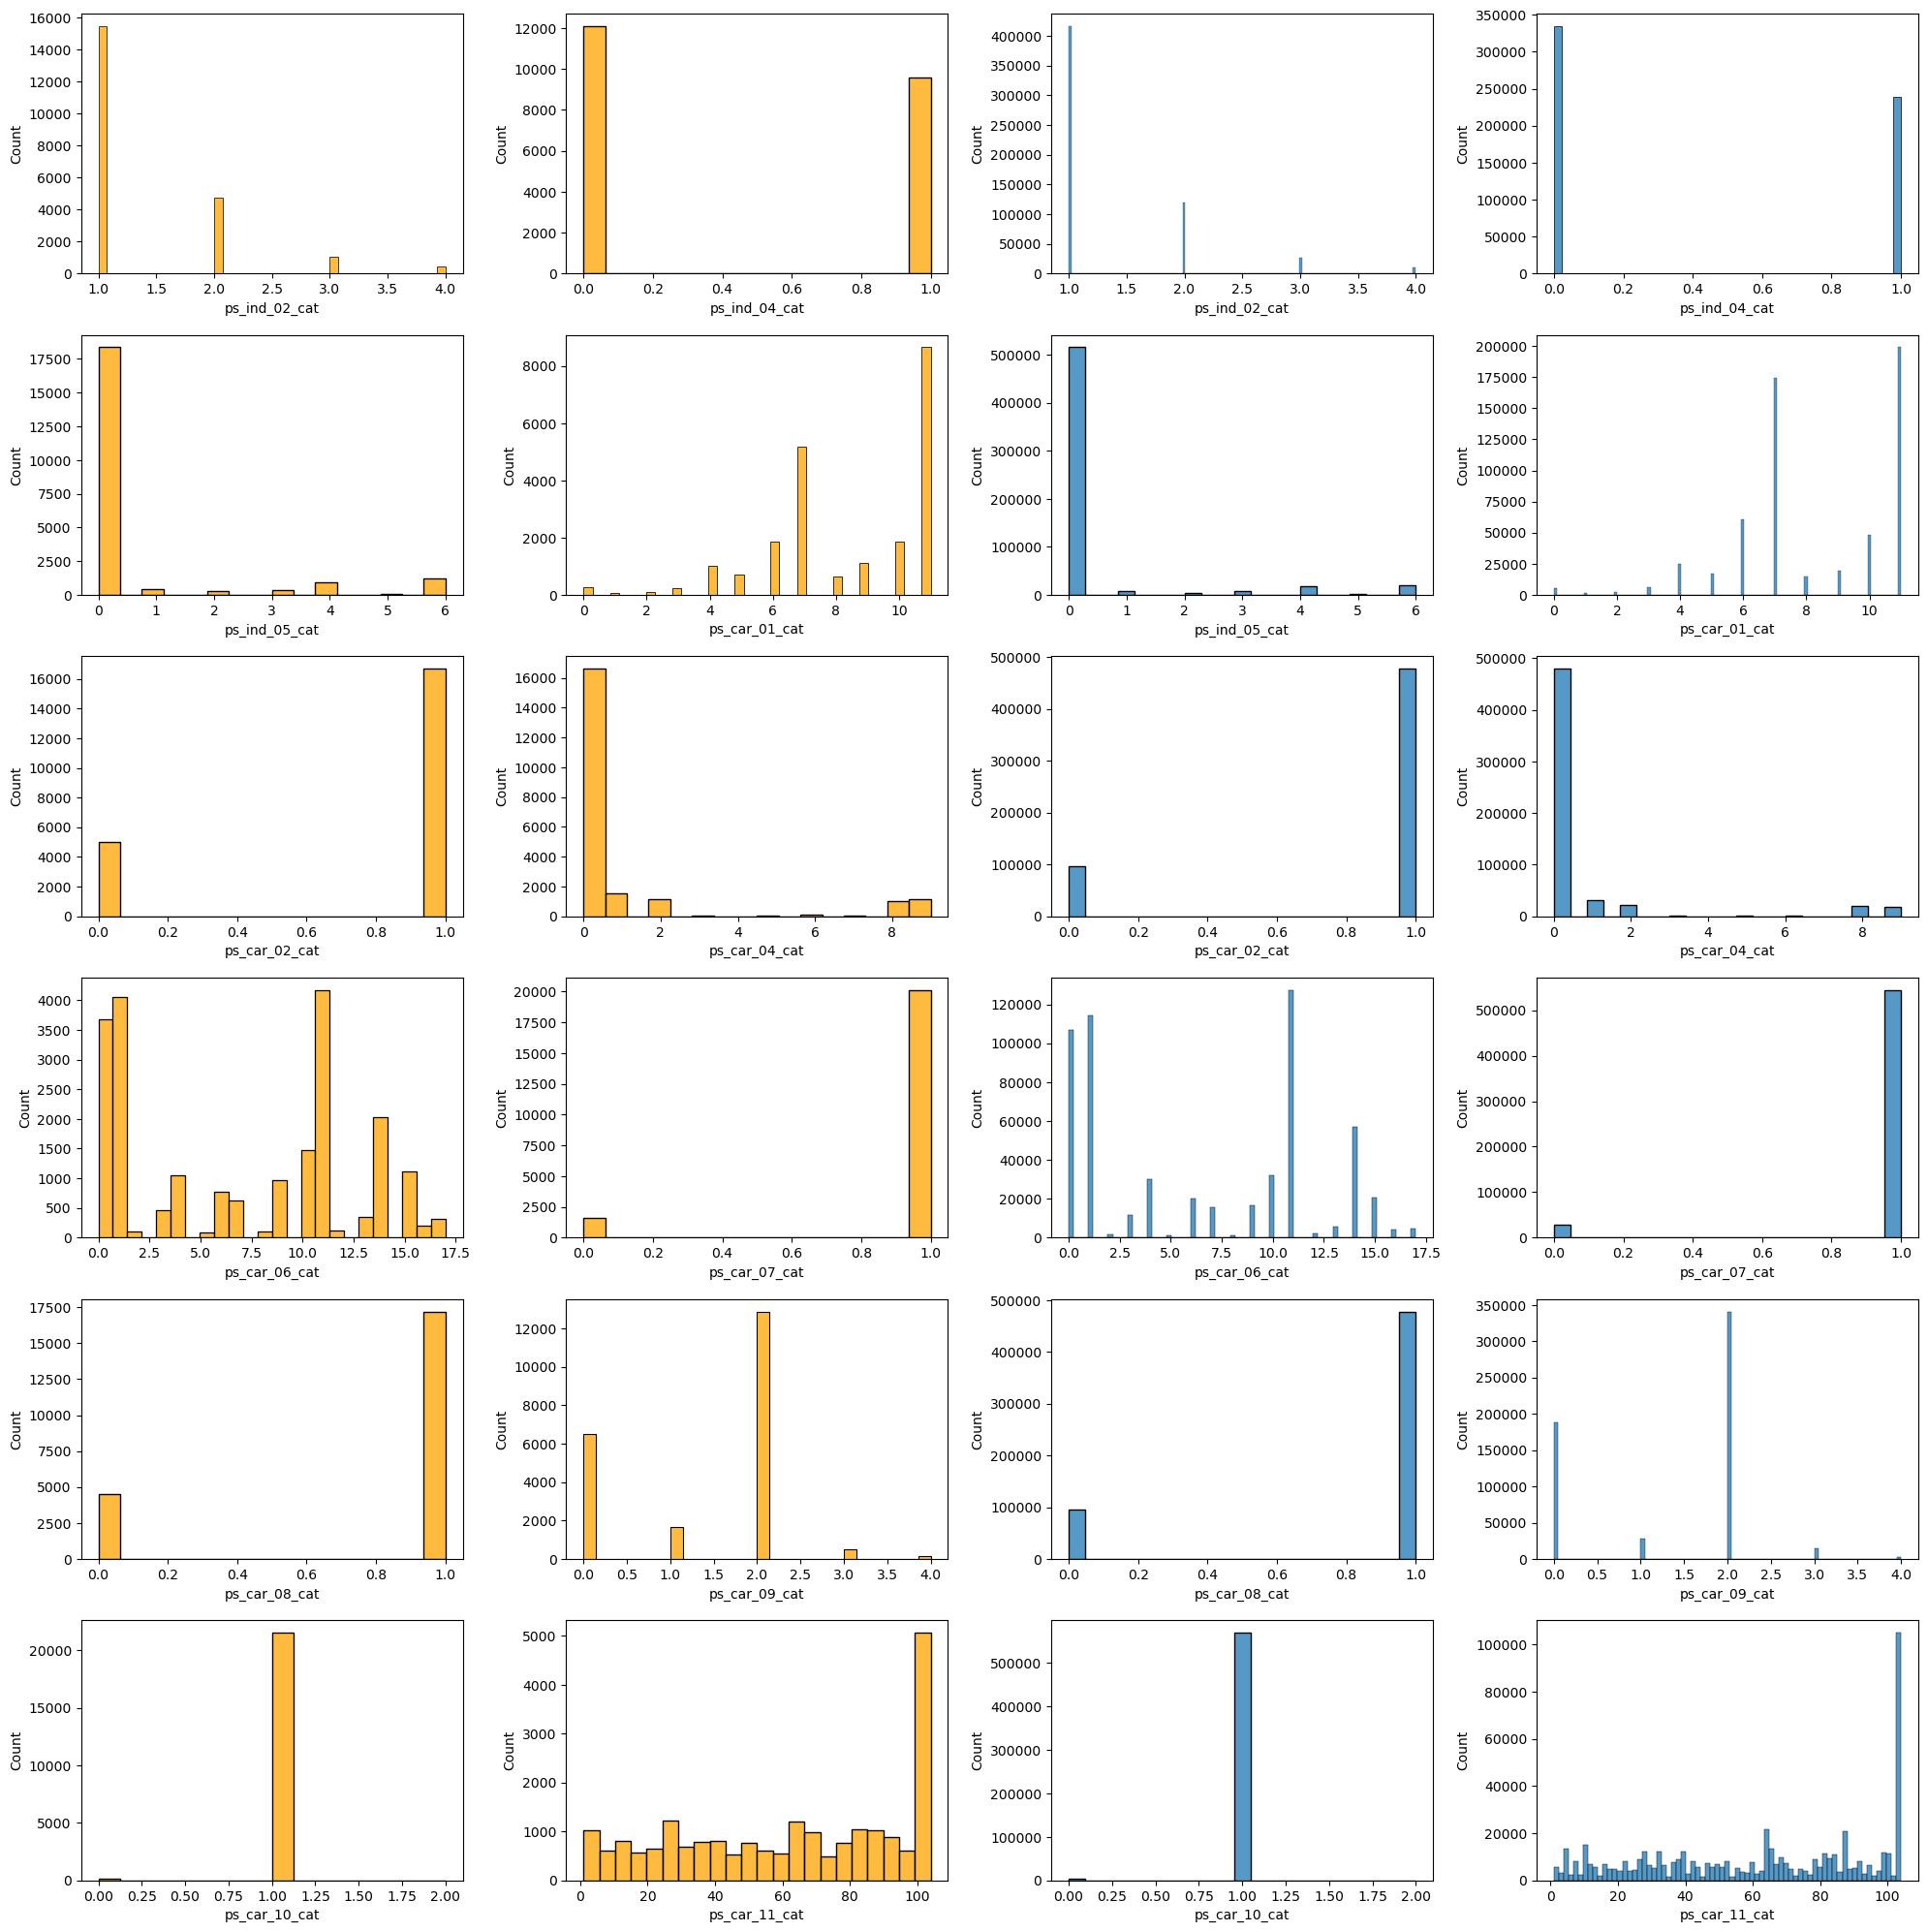

In [93]:
figure, axs = plt.subplots(nrows=(len(col_cat)//2), ncols=4)
figure.set_size_inches(20,20)

for i, col in enumerate(train_y1_ii[col_cat]):
    sns.histplot(train_y1_ii, x=col,color='orange',ax=axs[i//2,i%2])
    sns.histplot(train_y0_ii, x=col,ax=axs[i//2,i%2+2])
figure.tight_layout() 

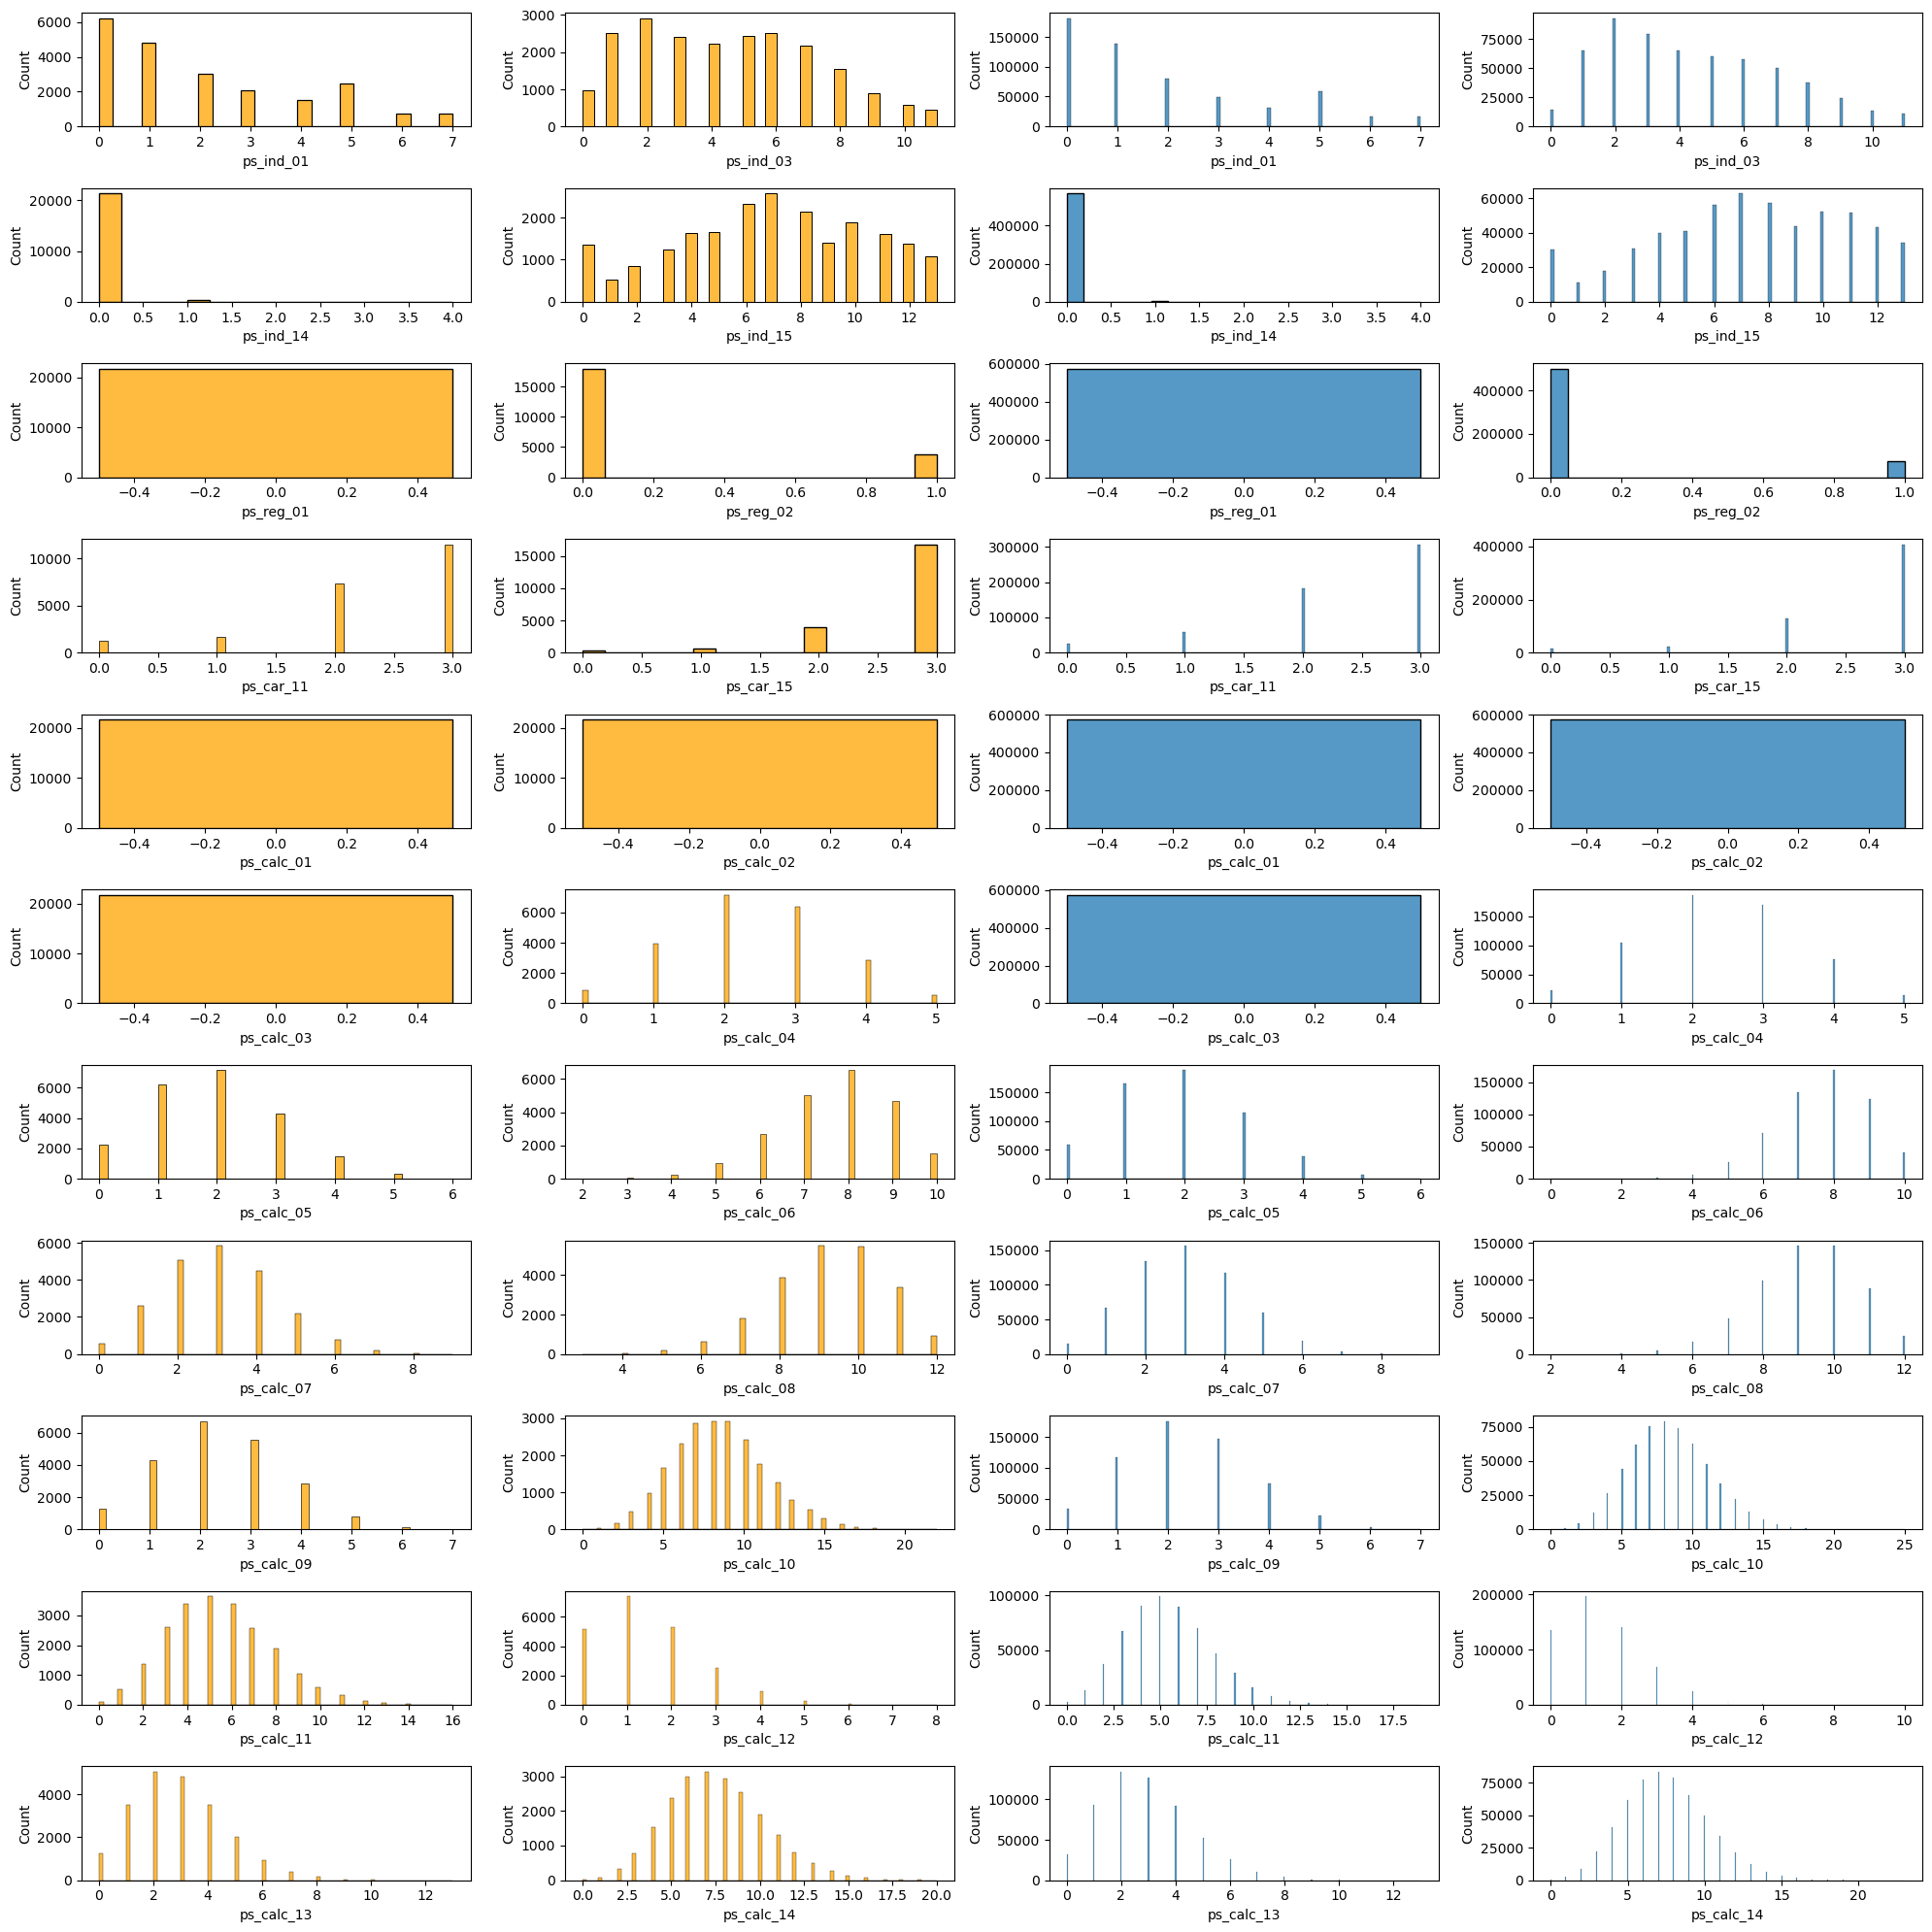

In [94]:
figure, axs = plt.subplots(nrows=(len(col_ord)//2), ncols=4)
figure.set_size_inches(20,20)

for i, col in enumerate(train_y1_ii[col_ord]):
    sns.histplot(train_y1_ii, x=col,color='orange',ax=axs[i//2,i%2])
    sns.histplot(train_y0_ii, x=col,ax=axs[i//2,i%2+2])
figure.tight_layout() 

IndexError: index 8 is out of bounds for axis 0 with size 8

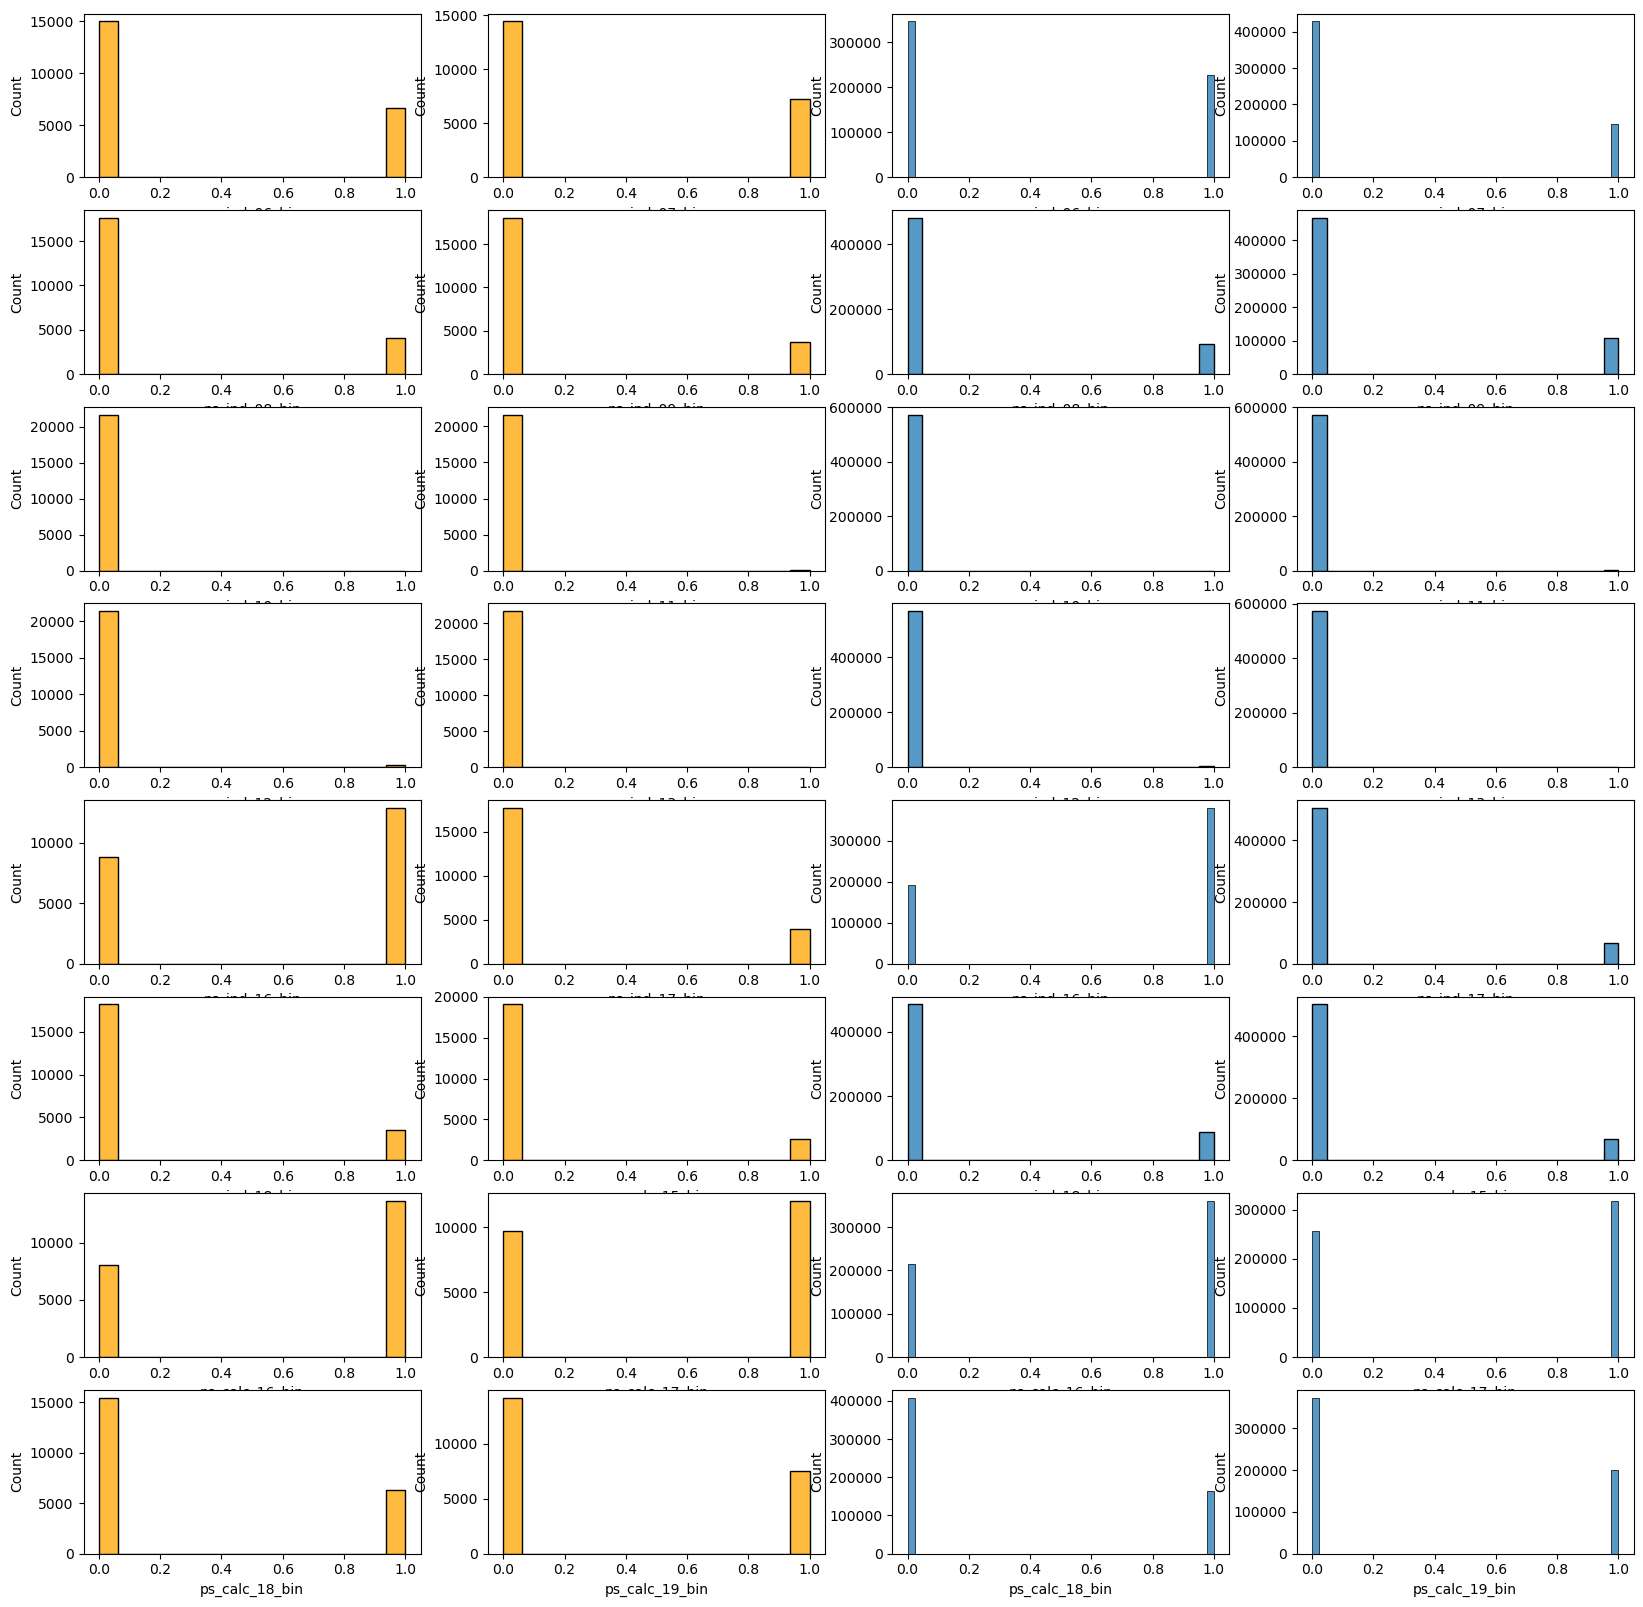

In [95]:
figure, axs = plt.subplots(nrows=(len(col_bin)//2), ncols=4)
figure.set_size_inches(20,20)

for i, col in enumerate(train_y1_ii[col_bin]):
    sns.histplot(train_y1_ii, x=col,color='orange',ax=axs[i//2,i%2])
    sns.histplot(train_y0_ii, x=col,ax=axs[i//2,i%2+2])
figure.tight_layout() 

결측치 대체 후 데이터 분포 확인하여 전체적으로 대체 전 데이터 분포와 유사함을 확인하였다. 

위와 동일한 방법을 test set에도 동일하게 적용해주었다. 단, 제공된 test set은 kaggle score submission용이기 때문에 y의 true label을 알 방법이 없다. 때문에 모든 모델들에 대해 predictions을 추출한 뒤, 각 모델마다 kaggle에 제출한 다음에 나오는 점수로 모델 성능을 비교해보겠다. 

In [2]:
test = pd.read_csv('test.csv')
del test['id']
col_names = list(test.columns)

#################################
for i in range(len(col_names)):
    for j in range(595212):
        if test[col_names[i]][j] == -1:
            test[col_names[i]][j] = np.nan
        else:
            pass
        
del test['ps_car_03_cat']
del test['ps_car_05_cat']

#################################
col_cat=[]
col_num=[]
col_bin=[]
col_ord=[]
for i in test.columns.to_list()[1:]:
    if '_cat' in i:
        col_cat.append(i)
    elif re.search('_bin',i):
        col_bin.append(i)
    elif test[i].nunique()>100:
        col_num.append(i)
    else:
        col_ord.append(i)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
display(col_cat)
display(col_num)
display(col_bin)
display(col_ord)

In [98]:
test = pd.read_csv('test.csv')
del test['id']
col_names = list(test.columns)

#################################
for i in range(len(col_names)):
    for j in range(595212):
        if test[col_names[i]][j] == -1:
            test[col_names[i]][j] = np.nan
        else:
            pass
        
del test['ps_car_03_cat']
del test['ps_car_05_cat']

#################################
col_cat=[]
col_num=[]
col_bin=[]
col_ord=[]
for i in test.columns.to_list()[1:]:
    if '_cat' in i:
        col_cat.append(i)
    elif re.search('_bin',i):
        col_bin.append(i)
    elif test[i].nunique()>100:
        col_num.append(i)
    else:
        col_ord.append(i)
        

#################################
rows= []

for var1 in test[col_bin]:
    col = []
    for var2 in test[col_bin]:
        cramers =cramers_V(test[col_bin][var1], test[col_bin][var2]) # Cramer's V test
        col.append(round(cramers,4)) # Keeping of the rounded value of the Cramer's V  
    rows.append(col)
cramers_results = np.array(rows)
corr_bin = pd.DataFrame(cramers_results, columns =test[col_bin].columns, index =test[col_bin].columns)

rows= []

for var1 in test[col_ord]:
    col = []
    for var2 in test[col_ord]:
        cramers =cramers_V(test[col_ord][var1], test[col_ord][var2]) # Cramer's V test
        col.append(round(cramers,4)) # Keeping of the rounded value of the Cramer's V  
    rows.append(col)
cramers_results = np.array(rows)
corr_ord = pd.DataFrame(cramers_results, columns =test[col_ord].columns, index =test[col_ord].columns)

rows= []

for var1 in test[col_cat]:
    col = []
    for var2 in test[col_cat]:
        cramers =cramers_V(test[col_cat][var1], test[col_cat][var2]) # Cramer's V test
        col.append(round(cramers,4)) # Keeping of the rounded value of the Cramer's V  
    rows.append(col)
cramers_results = np.array(rows)
corr_cat = pd.DataFrame(cramers_results, columns =test[col_cat].columns, index =test[col_cat].columns)

#################################

imp_num=imp_num.fit(test[col_num])
test[col_ord] = test[col_ord].fillna(0).astype(np.int64, errors='ignore').replace({-1: np.nan})
imp_ord=imp_ord.fit(test[col_ord])
imp_cat=imp_cat.fit(test[col_cat])

imp_num_test=imp_num.transform(test[col_num])
imp_cat_test=imp_cat.transform(test[col_cat])
imp_ord_test=imp_ord.transform(test[col_ord])

x_test_num = pd.DataFrame(imp_num_test, columns=test[col_num].columns)
x_test_cat = pd.DataFrame(imp_cat_test, columns=test[col_cat].columns)
x_test_ord = pd.DataFrame(imp_ord_test, columns=test[col_ord].columns)

#################################

test_ii = pd.concat([x_test_num,x_test_cat,x_test_ord,test[col_bin]],axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


[IterativeImputer] Completing matrix with shape (892816, 4)
[IterativeImputer] Change: 1.1419687976290187, scaled tolerance: 0.004423516700500001 
[IterativeImputer] Change: 0.028080975206622893, scaled tolerance: 0.004423516700500001 
[IterativeImputer] Change: 0.00011339444455149561, scaled tolerance: 0.004423516700500001 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (892816, 21)
[IterativeImputer] Change: 0.0, scaled tolerance: 0.028 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (892816, 12)
[IterativeImputer] Change: 5.0, scaled tolerance: 0.10400000000000001 
[IterativeImputer] Change: 4.0, scaled tolerance: 0.10400000000000001 
[IterativeImputer] Change: 2.0, scaled tolerance: 0.10400000000000001 
[IterativeImputer] Change: 4.0, scaled tolerance: 0.10400000000000001 
[IterativeImputer] Change: 4.0, scaled tolerance: 0.10400000000000001 
[IterativeImputer] Change: 2.0, s

/opt/conda/lib/python3.7/site-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


[IterativeImputer] Completing matrix with shape (892816, 12)
[IterativeImputer] Completing matrix with shape (892816, 21)


전처리가 끝난 데이터를 csv로 저장해주기

In [99]:
train_ii.to_csv('train_preprocessed.csv')
test_ii.to_csv('test_preprocessed.csv')

해당 데이터를 Stray Algorithm과 HDoutliers에 대입하면 모델 돌아가는 시간이 너무 오래 걸려서 데이터를 축소하기로 결정. 595212행 중 5%만을 사용하기로 결정하였다. 이 때, 5%를 sampling하게 된다면 이상치가 안 뽑힐 확률이 있으므로 stratified sampling을 사용하여 정상치와 이상치 각각 5%씩 sampling 될 수 있게 설정하였다. 그리고 5%중 20%를 다시 test set으로 설정하였다. 

In [8]:
from optuna.samplers import TPESampler

In [18]:
train = pd.read_csv('train_preprocessed.csv', index_col = 0)
train_y = train['target']
del train['target']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(train, train_y, test_size=0.1,stratify=train_y, random_state=1111)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, test_size=0.2,stratify=y_test, random_state=1111)

In [25]:
train_reduced = pd.concat([X_train, y_train], axis = 1)
test_reduced = pd.concat([X_test, y_test], axis = 1)

In [26]:
train_reduced.to_csv('train_reduced.csv')
test_reduced.to_csv('test_reduced.csv')

HDoutliers 용

In [28]:
train = pd.read_csv('train_preprocessed.csv', index_col = 0)
train_y = train['target']
del train['target']

X_train, X_test, y_train, y_test = train_test_split(train, train_y, test_size=0.03,stratify=train_y, random_state=1111)

X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, test_size=0.2,stratify=y_test, random_state=1111)

train_reduced = pd.concat([X_train, y_train], axis = 1)
test_reduced = pd.concat([X_test, y_test], axis = 1)

train_reduced.to_csv('train_reduced03.csv')
test_reduced.to_csv('test_reduced03.csv')